In [1]:
# ============================================================================
# CELL 1: Set Up Directories
# ============================================================================

import os

# Define local paths
BASE_DIR = os.path.abspath("Pipe Counter")
TRAIN_PATH = os.path.join(BASE_DIR, 'train')
VALID_PATH = os.path.join(BASE_DIR, 'valid')
TEST_PATH = os.path.join(BASE_DIR, 'test')

# Verify paths exist
for path in [BASE_DIR, TRAIN_PATH, VALID_PATH, TEST_PATH]:
    if os.path.exists(path):
        print(f"✓ Found: {path}")
    else:
        print(f"✗ Missing: {path}")

✓ Found: /Users/kutadgu/Documents/MachineLearning/Pipe Counter
✓ Found: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/train
✓ Found: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/valid
✓ Found: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/test


In [2]:
# ============================================================================
# CELL 2: Import Libraries and Set Device
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from collections import defaultdict
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cpu


In [4]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [5]:
# ============================================================================
# CELL 3: Dataset Class for COCO Format
# ============================================================================

class PipeDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        
        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create image id to annotations mapping
        self.image_info = {img['id']: img for img in self.coco_data['images']}
        
        # Group annotations by image_id
        self.annotations_by_image = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.annotations_by_image[ann['image_id']].append(ann)
        
        # Get list of image IDs that have annotations
        self.image_ids = list(self.annotations_by_image.keys())
        
        print(f"Dataset loaded: {len(self.image_ids)} images with annotations")
        
        # Calculate pipe count distribution
        pipe_counts = [len(self.annotations_by_image[img_id]) for img_id in self.image_ids]
        print(f"Pipe count stats - Min: {min(pipe_counts)}, Max: {max(pipe_counts)}, Mean: {np.mean(pipe_counts):.2f}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Get image ID
        image_id = self.image_ids[idx]
        
        # Get image info
        image_info = self.image_info[image_id]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # Get annotations for this image
        annotations = self.annotations_by_image[image_id]
        
        # Extract bounding boxes and labels
        boxes = []
        labels = []
        areas = []
        
        for ann in annotations:
            bbox = ann['bbox']  # COCO format: [x, y, width, height]
            
            # Convert to [x1, y1, x2, y2] format
            x1, y1, w, h = bbox
            x2 = x1 + w
            y2 = y1 + h
            
            # Ensure valid bounding box
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(image.width, x2)
            y2 = min(image.height, y2)
            
            if x2 > x1 and y2 > y1:  # Valid box
                boxes.append([x1, y1, x2, y2])
                labels.append(1)  # Pipe class (1-indexed for torchvision)
                areas.append(w * h)
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id]),
            'area': areas,
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }
        
        # Apply transforms
        if self.transforms:
            image = self.transforms(image)
        
        return image, target


In [6]:
# ============================================================================
# CELL 4: Data Transforms and Augmentation
# ============================================================================

def get_transform(train=True):
    # ImageNet normalization (used by Faster R-CNN pretrained backbones)
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    if train:
        return transforms.Compose([
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            ),
            transforms.ToTensor(),
            normalize
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])

def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
# ============================================================================
# CELL 5: Create Datasets and DataLoaders
# ============================================================================

# Find annotation files
train_ann_file = None
valid_ann_file = None
test_ann_file = None

# Look for common annotation file names
for filename in ['annotations.json', 'instances_train.json', '_annotations.coco.json']:
    train_path = os.path.join(TRAIN_PATH, filename)
    if os.path.exists(train_path):
        train_ann_file = train_path
        break

for filename in ['annotations.json', 'instances_val.json', '_annotations.coco.json']:
    valid_path = os.path.join(VALID_PATH, filename)
    if os.path.exists(valid_path):
        valid_ann_file = valid_path
        break

for filename in ['annotations.json', 'instances_test.json', '_annotations.coco.json']:
    test_path = os.path.join(TEST_PATH, filename)
    if os.path.exists(test_path):
        test_ann_file = test_path
        break

print(f"Train annotations: {train_ann_file}")
print(f"Valid annotations: {valid_ann_file}")
print(f"Test annotations: {test_ann_file}")

# Create datasets
train_dataset = PipeDataset(
    root_dir=TRAIN_PATH,
    annotation_file=train_ann_file,
    transforms=get_transform(train=True)
)

valid_dataset = PipeDataset(
    root_dir=VALID_PATH,
    annotation_file=valid_ann_file,
    transforms=get_transform(train=False)
)

if test_ann_file:
    test_dataset = PipeDataset(
        root_dir=TEST_PATH,
        annotation_file=test_ann_file,
        transforms=get_transform(train=False)
)

# Create data loaders
BATCH_SIZE = 4  # Adjust based on your GPU memory
NUM_WORKERS = 0  # Set to 0 for Jupyter notebook compatibility

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

if test_ann_file:
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
)

print(f"Train batches: {len(train_loader)}")
print(f"Valid batches: {len(valid_loader)}")
if test_ann_file:
    print(f"Test batches: {len(test_loader)}")


Train annotations: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/train/_annotations.coco.json
Valid annotations: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/valid/_annotations.coco.json
Test annotations: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/test/_annotations.coco.json
Dataset loaded: 1668 images with annotations
Pipe count stats - Min: 1, Max: 903, Mean: 63.26
Dataset loaded: 673 images with annotations
Pipe count stats - Min: 1, Max: 987, Mean: 75.55
Dataset loaded: 60 images with annotations
Pipe count stats - Min: 1, Max: 393, Mean: 55.60
Train batches: 417
Valid batches: 169
Test batches: 15


Sample training images:


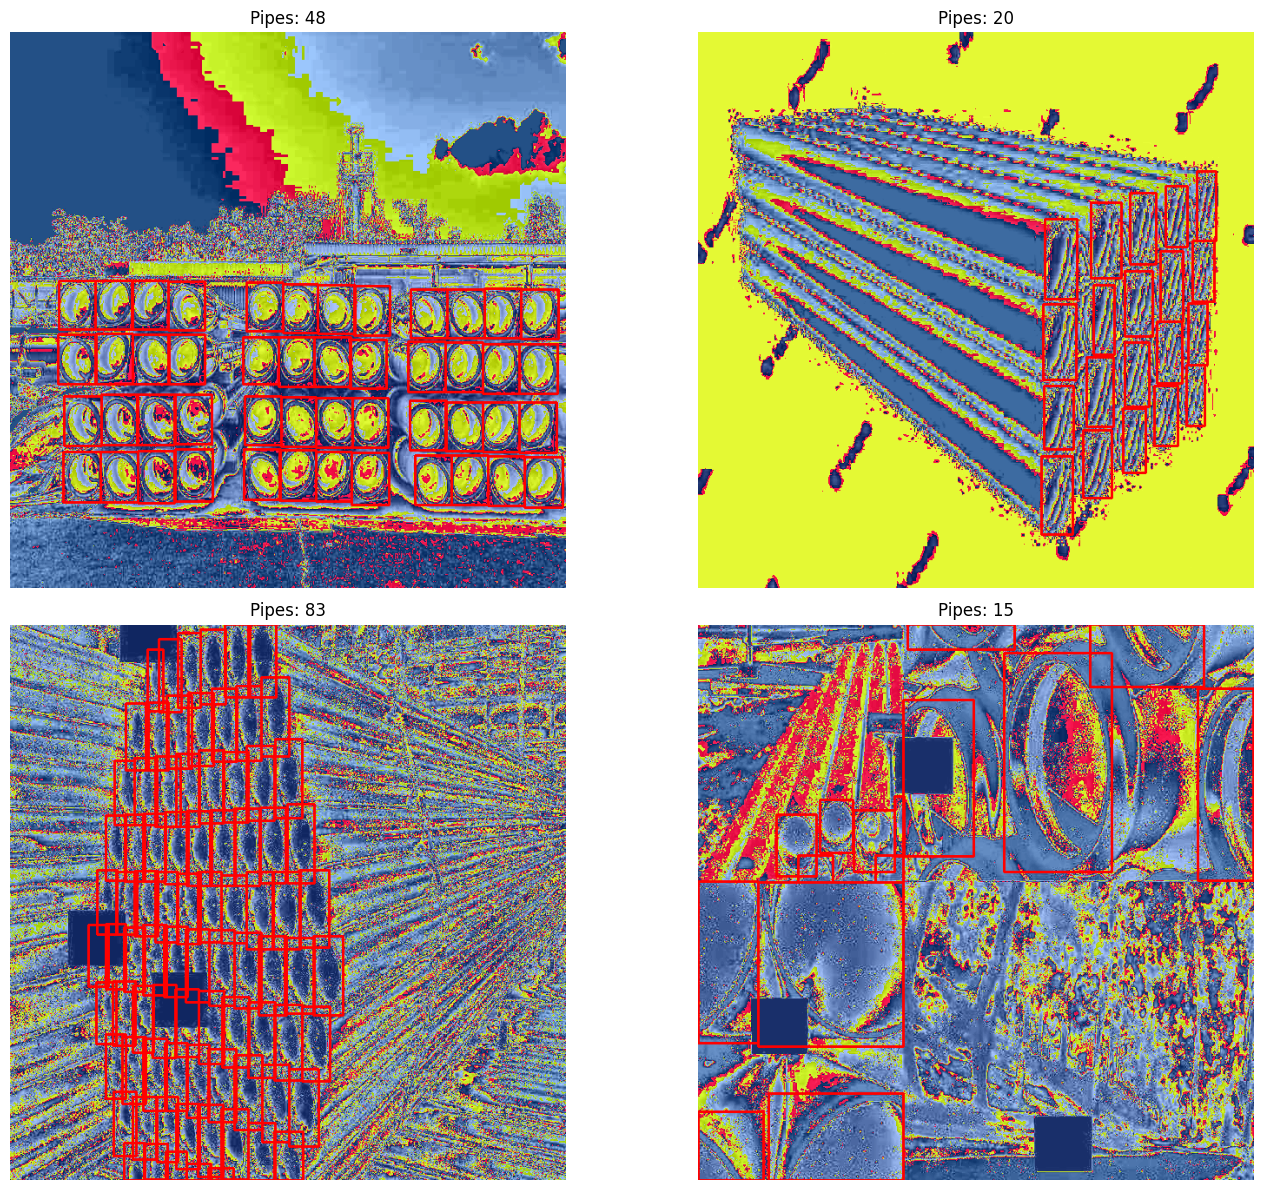

In [8]:
# ============================================================================
# CELL 6: Visualize Sample Data
# ============================================================================

def visualize_sample_data(dataset, num_samples=4):
    """Visualize sample images with bounding boxes"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(dataset))):
        image, target = dataset[i]
        
        # Convert tensor to PIL Image
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        
        # Convert to numpy array for visualization
        image_np = np.array(image)
        
        # Draw bounding boxes
        for box in target['boxes']:
            x1, y1, x2, y2 = box.cpu().numpy()
            cv2.rectangle(image_np, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        
        axes[i].imshow(image_np)
        axes[i].set_title(f'Pipes: {len(target["boxes"])}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training data
print("Sample training images:")
visualize_sample_data(train_dataset)


In [9]:
# ============================================================================
# CELL 7: Define Fast R-CNN Model
# ============================================================================

def create_model(num_classes=2):  # 1 class (pipe) + background
    """Create Fast R-CNN model with ResNet-50 backbone"""
    
    # Load pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Create model
model = create_model(num_classes=2)  # pipe + background
model.roi_heads.detections_per_img = 500 # manually set the instance per image limit higher
model.to(device)

print("Model created successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model created successfully!
Model parameters: 43,256,153
Trainable parameters: 43,030,809


In [10]:
# ============================================================================
# CELL 8: Training Configuration
# ============================================================================

# Training hyperparameters
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
MOMENTUM = 0.9
NUM_EPOCHS = 6
PATIENCE = 10  # Early stopping patience

# Optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

# For tracking training progress
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print("Training configuration:")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Device: {device}")


Training configuration:
Learning rate: 0.001
Batch size: 4
Epochs: 6
Device: cpu


In [11]:
# ============================================================================
# CELL 9: Training Functions
# ============================================================================

def train_one_epoch(model, optimizer, data_loader, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    
    for batch_idx, (images, targets) in enumerate(progress_bar):
        # Move to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += losses.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': losses.item(),
            'avg_loss': running_loss / (batch_idx + 1)
        })
    
    return running_loss / len(data_loader)

def validate_one_epoch(model, data_loader, device):
    """Validate for one epoch"""
    model.train()  # Keep in training mode for loss calculation
    running_loss = 0.0
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)
        
        for batch_idx, (images, targets) in enumerate(progress_bar):
            # Move to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Update running loss
            running_loss += losses.item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': losses.item(),
                'avg_loss': running_loss / (batch_idx + 1)
            })
    
    return running_loss / len(data_loader)


In [12]:
# ============================================================================
# CELL 10: Training Loop
# ============================================================================
def count_pipes_from_targets(targets):
    """Helper to count pipes in targets (ground truth)"""
    return [len(t["boxes"]) for t in targets]

def count_pipes_from_outputs(outputs, conf_thresh=0.5):
    """Helper to count predicted pipes from model outputs with optional confidence threshold"""
    return [int((o["scores"] > conf_thresh).sum().item()) for o in outputs]

LOG_EVERY_N_BATCHES = 10  # Change this to control frequency of debug prints

print("Starting training...")
print("=" * 50)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 30)
    
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (images, targets) in enumerate(tqdm(train_loader)):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        batch_loss = losses.item()
        epoch_loss += batch_loss
        
        if (batch_idx + 1) % LOG_EVERY_N_BATCHES == 0:
            with torch.no_grad():
                model.eval()
                outputs = model(images)
                model.train()
                
                gt_counts = count_pipes_from_targets(targets)
                pred_counts = count_pipes_from_outputs(outputs)
                
                print(f"\nBatch {batch_idx + 1}/{len(train_loader)}")
                print(f"Batch Loss: {batch_loss:.4f}")
                for i, (gt, pred) in enumerate(zip(gt_counts, pred_counts)):
                    print(f"Image {i}: True pipes = {gt}, Predicted pipes = {pred}")
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    val_loss = validate_one_epoch(model, valid_loader, device)
    val_losses.append(val_loss)
    
    scheduler.step()
    
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Early stopping and checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, 'best_pipe_model.pth')  # Saved locally now
        print("✓ New best model saved!")
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break
    
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, f'checkpoint_epoch_{epoch+1}.pth')

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...

Epoch 1/6
------------------------------


  2%|▏         | 10/417 [01:57<1:25:31, 12.61s/it]


Batch 10/417
Batch Loss: 1.7527
Image 0: True pipes = 95, Predicted pipes = 0
Image 1: True pipes = 199, Predicted pipes = 0
Image 2: True pipes = 18, Predicted pipes = 0
Image 3: True pipes = 73, Predicted pipes = 0


  5%|▍         | 20/417 [03:52<1:22:47, 12.51s/it]


Batch 20/417
Batch Loss: 1.3010
Image 0: True pipes = 20, Predicted pipes = 23
Image 1: True pipes = 11, Predicted pipes = 6
Image 2: True pipes = 350, Predicted pipes = 111
Image 3: True pipes = 24, Predicted pipes = 27


  7%|▋         | 30/417 [05:50<1:24:21, 13.08s/it]


Batch 30/417
Batch Loss: 1.2309
Image 0: True pipes = 80, Predicted pipes = 77
Image 1: True pipes = 24, Predicted pipes = 41
Image 2: True pipes = 245, Predicted pipes = 105
Image 3: True pipes = 259, Predicted pipes = 166


 10%|▉         | 40/417 [07:47<1:21:16, 12.93s/it]


Batch 40/417
Batch Loss: 1.0561
Image 0: True pipes = 7, Predicted pipes = 16
Image 1: True pipes = 12, Predicted pipes = 15
Image 2: True pipes = 10, Predicted pipes = 29
Image 3: True pipes = 152, Predicted pipes = 86


 12%|█▏        | 50/417 [09:46<1:19:31, 13.00s/it]


Batch 50/417
Batch Loss: 1.4039
Image 0: True pipes = 72, Predicted pipes = 71
Image 1: True pipes = 206, Predicted pipes = 84
Image 2: True pipes = 45, Predicted pipes = 38
Image 3: True pipes = 29, Predicted pipes = 30


 14%|█▍        | 60/417 [11:43<1:16:07, 12.80s/it]


Batch 60/417
Batch Loss: 0.6942
Image 0: True pipes = 8, Predicted pipes = 8
Image 1: True pipes = 65, Predicted pipes = 63
Image 2: True pipes = 101, Predicted pipes = 87
Image 3: True pipes = 63, Predicted pipes = 68


 17%|█▋        | 70/417 [13:42<1:13:44, 12.75s/it]


Batch 70/417
Batch Loss: 0.6958
Image 0: True pipes = 8, Predicted pipes = 9
Image 1: True pipes = 41, Predicted pipes = 40
Image 2: True pipes = 25, Predicted pipes = 29
Image 3: True pipes = 64, Predicted pipes = 58


 19%|█▉        | 80/417 [15:38<1:11:58, 12.82s/it]


Batch 80/417
Batch Loss: 0.7456
Image 0: True pipes = 13, Predicted pipes = 12
Image 1: True pipes = 60, Predicted pipes = 41
Image 2: True pipes = 50, Predicted pipes = 51
Image 3: True pipes = 20, Predicted pipes = 24


 22%|██▏       | 90/417 [17:35<1:10:01, 12.85s/it]


Batch 90/417
Batch Loss: 0.7652
Image 0: True pipes = 195, Predicted pipes = 175
Image 1: True pipes = 38, Predicted pipes = 43
Image 2: True pipes = 24, Predicted pipes = 26
Image 3: True pipes = 11, Predicted pipes = 10


 24%|██▍       | 100/417 [19:33<1:08:53, 13.04s/it]


Batch 100/417
Batch Loss: 1.3812
Image 0: True pipes = 8, Predicted pipes = 17
Image 1: True pipes = 293, Predicted pipes = 229
Image 2: True pipes = 134, Predicted pipes = 120
Image 3: True pipes = 260, Predicted pipes = 183


 26%|██▋       | 110/417 [21:32<1:06:36, 13.02s/it]


Batch 110/417
Batch Loss: 0.6666
Image 0: True pipes = 7, Predicted pipes = 11
Image 1: True pipes = 21, Predicted pipes = 20
Image 2: True pipes = 157, Predicted pipes = 86
Image 3: True pipes = 6, Predicted pipes = 10


 29%|██▉       | 120/417 [23:29<1:03:52, 12.90s/it]


Batch 120/417
Batch Loss: 0.4837
Image 0: True pipes = 98, Predicted pipes = 98
Image 1: True pipes = 17, Predicted pipes = 28
Image 2: True pipes = 50, Predicted pipes = 52
Image 3: True pipes = 38, Predicted pipes = 39


 31%|███       | 130/417 [25:27<1:02:02, 12.97s/it]


Batch 130/417
Batch Loss: 0.6975
Image 0: True pipes = 101, Predicted pipes = 114
Image 1: True pipes = 33, Predicted pipes = 36
Image 2: True pipes = 148, Predicted pipes = 138
Image 3: True pipes = 7, Predicted pipes = 7


 34%|███▎      | 140/417 [27:24<59:14, 12.83s/it]  


Batch 140/417
Batch Loss: 0.5549
Image 0: True pipes = 24, Predicted pipes = 27
Image 1: True pipes = 21, Predicted pipes = 19
Image 2: True pipes = 51, Predicted pipes = 50
Image 3: True pipes = 49, Predicted pipes = 46


 36%|███▌      | 150/417 [29:21<57:34, 12.94s/it]


Batch 150/417
Batch Loss: 0.7404
Image 0: True pipes = 24, Predicted pipes = 26
Image 1: True pipes = 18, Predicted pipes = 31
Image 2: True pipes = 11, Predicted pipes = 11
Image 3: True pipes = 81, Predicted pipes = 67


 38%|███▊      | 160/417 [31:19<55:04, 12.86s/it]


Batch 160/417
Batch Loss: 0.6502
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 40, Predicted pipes = 37
Image 2: True pipes = 9, Predicted pipes = 9
Image 3: True pipes = 32, Predicted pipes = 30


 41%|████      | 170/417 [33:17<53:33, 13.01s/it]


Batch 170/417
Batch Loss: 0.6006
Image 0: True pipes = 27, Predicted pipes = 25
Image 1: True pipes = 80, Predicted pipes = 77
Image 2: True pipes = 78, Predicted pipes = 77
Image 3: True pipes = 151, Predicted pipes = 142


 43%|████▎     | 180/417 [35:14<50:48, 12.86s/it]


Batch 180/417
Batch Loss: 0.8008
Image 0: True pipes = 87, Predicted pipes = 78
Image 1: True pipes = 34, Predicted pipes = 21
Image 2: True pipes = 62, Predicted pipes = 61
Image 3: True pipes = 32, Predicted pipes = 32


 46%|████▌     | 190/417 [37:13<48:52, 12.92s/it]


Batch 190/417
Batch Loss: 0.6282
Image 0: True pipes = 25, Predicted pipes = 29
Image 1: True pipes = 7, Predicted pipes = 8
Image 2: True pipes = 77, Predicted pipes = 81
Image 3: True pipes = 48, Predicted pipes = 48


 48%|████▊     | 200/417 [39:10<46:19, 12.81s/it]


Batch 200/417
Batch Loss: 0.5111
Image 0: True pipes = 90, Predicted pipes = 94
Image 1: True pipes = 83, Predicted pipes = 75
Image 2: True pipes = 1, Predicted pipes = 2
Image 3: True pipes = 32, Predicted pipes = 34


 50%|█████     | 210/417 [41:07<44:44, 12.97s/it]


Batch 210/417
Batch Loss: 1.0248
Image 0: True pipes = 227, Predicted pipes = 118
Image 1: True pipes = 97, Predicted pipes = 100
Image 2: True pipes = 4, Predicted pipes = 6
Image 3: True pipes = 6, Predicted pipes = 10


 53%|█████▎    | 220/417 [43:05<42:38, 12.99s/it]


Batch 220/417
Batch Loss: 0.7114
Image 0: True pipes = 172, Predicted pipes = 127
Image 1: True pipes = 26, Predicted pipes = 33
Image 2: True pipes = 92, Predicted pipes = 96
Image 3: True pipes = 49, Predicted pipes = 49


 55%|█████▌    | 230/417 [45:01<39:56, 12.82s/it]


Batch 230/417
Batch Loss: 0.5957
Image 0: True pipes = 16, Predicted pipes = 22
Image 1: True pipes = 9, Predicted pipes = 9
Image 2: True pipes = 12, Predicted pipes = 20
Image 3: True pipes = 10, Predicted pipes = 11


 58%|█████▊    | 240/417 [47:01<38:10, 12.94s/it]


Batch 240/417
Batch Loss: 0.5315
Image 0: True pipes = 10, Predicted pipes = 14
Image 1: True pipes = 104, Predicted pipes = 110
Image 2: True pipes = 61, Predicted pipes = 59
Image 3: True pipes = 70, Predicted pipes = 74


 60%|█████▉    | 250/417 [48:57<35:43, 12.84s/it]


Batch 250/417
Batch Loss: 0.5922
Image 0: True pipes = 163, Predicted pipes = 148
Image 1: True pipes = 39, Predicted pipes = 39
Image 2: True pipes = 57, Predicted pipes = 51
Image 3: True pipes = 71, Predicted pipes = 70


 62%|██████▏   | 260/417 [50:54<33:33, 12.82s/it]


Batch 260/417
Batch Loss: 1.0855
Image 0: True pipes = 15, Predicted pipes = 16
Image 1: True pipes = 26, Predicted pipes = 24
Image 2: True pipes = 55, Predicted pipes = 48
Image 3: True pipes = 33, Predicted pipes = 58


 65%|██████▍   | 270/417 [52:52<31:57, 13.05s/it]


Batch 270/417
Batch Loss: 0.3448
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 39, Predicted pipes = 69
Image 2: True pipes = 557, Predicted pipes = 385
Image 3: True pipes = 15, Predicted pipes = 18


 67%|██████▋   | 280/417 [54:48<29:17, 12.83s/it]


Batch 280/417
Batch Loss: 0.7447
Image 0: True pipes = 41, Predicted pipes = 38
Image 1: True pipes = 29, Predicted pipes = 43
Image 2: True pipes = 38, Predicted pipes = 37
Image 3: True pipes = 82, Predicted pipes = 73


 70%|██████▉   | 290/417 [56:46<27:38, 13.06s/it]


Batch 290/417
Batch Loss: 0.2762
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 13, Predicted pipes = 14
Image 2: True pipes = 37, Predicted pipes = 42
Image 3: True pipes = 21, Predicted pipes = 20


 72%|███████▏  | 300/417 [58:44<25:13, 12.94s/it]


Batch 300/417
Batch Loss: 0.3137
Image 0: True pipes = 67, Predicted pipes = 70
Image 1: True pipes = 19, Predicted pipes = 20
Image 2: True pipes = 18, Predicted pipes = 20
Image 3: True pipes = 3, Predicted pipes = 3


 74%|███████▍  | 310/417 [1:00:41<22:56, 12.87s/it]


Batch 310/417
Batch Loss: 0.9891
Image 0: True pipes = 38, Predicted pipes = 38
Image 1: True pipes = 43, Predicted pipes = 46
Image 2: True pipes = 221, Predicted pipes = 102
Image 3: True pipes = 2, Predicted pipes = 2


 77%|███████▋  | 320/417 [1:02:37<20:43, 12.82s/it]


Batch 320/417
Batch Loss: 0.7128
Image 0: True pipes = 11, Predicted pipes = 12
Image 1: True pipes = 15, Predicted pipes = 20
Image 2: True pipes = 47, Predicted pipes = 44
Image 3: True pipes = 153, Predicted pipes = 130


 79%|███████▉  | 330/417 [1:04:36<18:59, 13.10s/it]


Batch 330/417
Batch Loss: 0.5740
Image 0: True pipes = 19, Predicted pipes = 22
Image 1: True pipes = 26, Predicted pipes = 36
Image 2: True pipes = 256, Predicted pipes = 155
Image 3: True pipes = 252, Predicted pipes = 198


 82%|████████▏ | 340/417 [1:06:32<16:19, 12.73s/it]


Batch 340/417
Batch Loss: 0.4418
Image 0: True pipes = 38, Predicted pipes = 53
Image 1: True pipes = 11, Predicted pipes = 10
Image 2: True pipes = 82, Predicted pipes = 85
Image 3: True pipes = 19, Predicted pipes = 27


 84%|████████▍ | 350/417 [1:08:29<14:16, 12.78s/it]


Batch 350/417
Batch Loss: 0.5137
Image 0: True pipes = 39, Predicted pipes = 26
Image 1: True pipes = 11, Predicted pipes = 16
Image 2: True pipes = 8, Predicted pipes = 10
Image 3: True pipes = 134, Predicted pipes = 127


 86%|████████▋ | 360/417 [1:10:26<12:11, 12.83s/it]


Batch 360/417
Batch Loss: 0.4721
Image 0: True pipes = 57, Predicted pipes = 50
Image 1: True pipes = 49, Predicted pipes = 45
Image 2: True pipes = 44, Predicted pipes = 46
Image 3: True pipes = 12, Predicted pipes = 13


 89%|████████▊ | 370/417 [1:12:22<10:06, 12.91s/it]


Batch 370/417
Batch Loss: 0.8119
Image 0: True pipes = 55, Predicted pipes = 52
Image 1: True pipes = 28, Predicted pipes = 25
Image 2: True pipes = 48, Predicted pipes = 29
Image 3: True pipes = 268, Predicted pipes = 218


 91%|█████████ | 380/417 [1:14:19<07:50, 12.71s/it]


Batch 380/417
Batch Loss: 0.8009
Image 0: True pipes = 8, Predicted pipes = 10
Image 1: True pipes = 193, Predicted pipes = 156
Image 2: True pipes = 61, Predicted pipes = 69
Image 3: True pipes = 25, Predicted pipes = 28


 94%|█████████▎| 390/417 [1:16:16<05:47, 12.86s/it]


Batch 390/417
Batch Loss: 0.4166
Image 0: True pipes = 29, Predicted pipes = 32
Image 1: True pipes = 16, Predicted pipes = 16
Image 2: True pipes = 10, Predicted pipes = 13
Image 3: True pipes = 82, Predicted pipes = 74


 96%|█████████▌| 400/417 [1:18:12<03:38, 12.85s/it]


Batch 400/417
Batch Loss: 0.7145
Image 0: True pipes = 59, Predicted pipes = 61
Image 1: True pipes = 66, Predicted pipes = 60
Image 2: True pipes = 68, Predicted pipes = 77
Image 3: True pipes = 121, Predicted pipes = 113


 98%|█████████▊| 410/417 [1:20:11<01:30, 12.94s/it]


Batch 410/417
Batch Loss: 0.2988
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 21, Predicted pipes = 23
Image 2: True pipes = 24, Predicted pipes = 27
Image 3: True pipes = 3, Predicted pipes = 7


100%|██████████| 417/417 [1:21:30<00:00, 11.73s/it]


Train Loss: 0.7475
Val Loss: 0.6822
LR: 0.001000
✓ New best model saved!

Epoch 2/6
------------------------------


  2%|▏         | 10/417 [01:58<1:27:38, 12.92s/it]


Batch 10/417
Batch Loss: 0.5732
Image 0: True pipes = 80, Predicted pipes = 77
Image 1: True pipes = 14, Predicted pipes = 14
Image 2: True pipes = 35, Predicted pipes = 34
Image 3: True pipes = 9, Predicted pipes = 8


  5%|▍         | 20/417 [03:56<1:25:43, 12.96s/it]


Batch 20/417
Batch Loss: 0.5821
Image 0: True pipes = 18, Predicted pipes = 25
Image 1: True pipes = 33, Predicted pipes = 33
Image 2: True pipes = 50, Predicted pipes = 51
Image 3: True pipes = 87, Predicted pipes = 45


  7%|▋         | 30/417 [05:55<1:24:07, 13.04s/it]


Batch 30/417
Batch Loss: 0.3039
Image 0: True pipes = 30, Predicted pipes = 29
Image 1: True pipes = 400, Predicted pipes = 359
Image 2: True pipes = 10, Predicted pipes = 13
Image 3: True pipes = 58, Predicted pipes = 58


 10%|▉         | 40/417 [07:51<1:20:16, 12.78s/it]


Batch 40/417
Batch Loss: 0.6591
Image 0: True pipes = 49, Predicted pipes = 42
Image 1: True pipes = 50, Predicted pipes = 59
Image 2: True pipes = 16, Predicted pipes = 16
Image 3: True pipes = 20, Predicted pipes = 15


 12%|█▏        | 50/417 [09:49<1:18:52, 12.89s/it]


Batch 50/417
Batch Loss: 0.4165
Image 0: True pipes = 79, Predicted pipes = 72
Image 1: True pipes = 10, Predicted pipes = 9
Image 2: True pipes = 22, Predicted pipes = 21
Image 3: True pipes = 14, Predicted pipes = 15


 14%|█▍        | 60/417 [11:48<1:16:45, 12.90s/it]


Batch 60/417
Batch Loss: 0.4880
Image 0: True pipes = 18, Predicted pipes = 18
Image 1: True pipes = 22, Predicted pipes = 25
Image 2: True pipes = 4, Predicted pipes = 5
Image 3: True pipes = 25, Predicted pipes = 26


 17%|█▋        | 70/417 [13:46<1:15:24, 13.04s/it]


Batch 70/417
Batch Loss: 0.7139
Image 0: True pipes = 131, Predicted pipes = 111
Image 1: True pipes = 305, Predicted pipes = 240
Image 2: True pipes = 9, Predicted pipes = 9
Image 3: True pipes = 28, Predicted pipes = 30


 19%|█▉        | 80/417 [15:43<1:12:00, 12.82s/it]


Batch 80/417
Batch Loss: 0.4570
Image 0: True pipes = 59, Predicted pipes = 66
Image 1: True pipes = 10, Predicted pipes = 12
Image 2: True pipes = 59, Predicted pipes = 59
Image 3: True pipes = 12, Predicted pipes = 13


 22%|██▏       | 90/417 [17:39<1:10:18, 12.90s/it]


Batch 90/417
Batch Loss: 0.9222
Image 0: True pipes = 27, Predicted pipes = 34
Image 1: True pipes = 47, Predicted pipes = 36
Image 2: True pipes = 93, Predicted pipes = 108
Image 3: True pipes = 12, Predicted pipes = 11


 24%|██▍       | 100/417 [19:37<1:08:00, 12.87s/it]


Batch 100/417
Batch Loss: 0.2815
Image 0: True pipes = 6, Predicted pipes = 8
Image 1: True pipes = 62, Predicted pipes = 58
Image 2: True pipes = 22, Predicted pipes = 26
Image 3: True pipes = 107, Predicted pipes = 102


 26%|██▋       | 110/417 [21:33<1:05:05, 12.72s/it]


Batch 110/417
Batch Loss: 0.5123
Image 0: True pipes = 14, Predicted pipes = 12
Image 1: True pipes = 76, Predicted pipes = 78
Image 2: True pipes = 9, Predicted pipes = 9
Image 3: True pipes = 34, Predicted pipes = 22


 29%|██▉       | 120/417 [23:29<1:03:11, 12.77s/it]


Batch 120/417
Batch Loss: 0.5303
Image 0: True pipes = 60, Predicted pipes = 61
Image 1: True pipes = 24, Predicted pipes = 27
Image 2: True pipes = 162, Predicted pipes = 136
Image 3: True pipes = 44, Predicted pipes = 40


 31%|███       | 130/417 [25:28<1:01:28, 12.85s/it]


Batch 130/417
Batch Loss: 0.5406
Image 0: True pipes = 36, Predicted pipes = 35
Image 1: True pipes = 9, Predicted pipes = 10
Image 2: True pipes = 56, Predicted pipes = 54
Image 3: True pipes = 48, Predicted pipes = 53


 34%|███▎      | 140/417 [27:24<59:16, 12.84s/it]  


Batch 140/417
Batch Loss: 0.5876
Image 0: True pipes = 4, Predicted pipes = 4
Image 1: True pipes = 51, Predicted pipes = 55
Image 2: True pipes = 94, Predicted pipes = 90
Image 3: True pipes = 12, Predicted pipes = 15


 36%|███▌      | 150/417 [29:22<57:45, 12.98s/it]


Batch 150/417
Batch Loss: 0.5300
Image 0: True pipes = 191, Predicted pipes = 126
Image 1: True pipes = 14, Predicted pipes = 16
Image 2: True pipes = 71, Predicted pipes = 54
Image 3: True pipes = 50, Predicted pipes = 51


 38%|███▊      | 160/417 [31:18<54:52, 12.81s/it]


Batch 160/417
Batch Loss: 0.9727
Image 0: True pipes = 112, Predicted pipes = 114
Image 1: True pipes = 104, Predicted pipes = 107
Image 2: True pipes = 62, Predicted pipes = 63
Image 3: True pipes = 221, Predicted pipes = 132


 41%|████      | 170/417 [33:14<52:36, 12.78s/it]


Batch 170/417
Batch Loss: 0.3804
Image 0: True pipes = 73, Predicted pipes = 81
Image 1: True pipes = 7, Predicted pipes = 7
Image 2: True pipes = 51, Predicted pipes = 49
Image 3: True pipes = 22, Predicted pipes = 25


 43%|████▎     | 180/417 [35:11<51:55, 13.14s/it]


Batch 180/417
Batch Loss: 0.3611
Image 0: True pipes = 26, Predicted pipes = 31
Image 1: True pipes = 39, Predicted pipes = 44
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 27, Predicted pipes = 39


 46%|████▌     | 190/417 [37:09<48:56, 12.94s/it]


Batch 190/417
Batch Loss: 0.5127
Image 0: True pipes = 65, Predicted pipes = 73
Image 1: True pipes = 170, Predicted pipes = 146
Image 2: True pipes = 32, Predicted pipes = 33
Image 3: True pipes = 140, Predicted pipes = 134


 48%|████▊     | 200/417 [39:05<47:08, 13.04s/it]


Batch 200/417
Batch Loss: 1.1500
Image 0: True pipes = 17, Predicted pipes = 17
Image 1: True pipes = 97, Predicted pipes = 96
Image 2: True pipes = 297, Predicted pipes = 250
Image 3: True pipes = 404, Predicted pipes = 269


 50%|█████     | 210/417 [41:02<44:34, 12.92s/it]


Batch 210/417
Batch Loss: 0.4265
Image 0: True pipes = 14, Predicted pipes = 14
Image 1: True pipes = 57, Predicted pipes = 53
Image 2: True pipes = 13, Predicted pipes = 15
Image 3: True pipes = 33, Predicted pipes = 33


 53%|█████▎    | 220/417 [43:00<42:11, 12.85s/it]


Batch 220/417
Batch Loss: 0.4730
Image 0: True pipes = 6, Predicted pipes = 11
Image 1: True pipes = 26, Predicted pipes = 31
Image 2: True pipes = 48, Predicted pipes = 47
Image 3: True pipes = 21, Predicted pipes = 20


 55%|█████▌    | 230/417 [44:57<40:13, 12.90s/it]


Batch 230/417
Batch Loss: 0.9117
Image 0: True pipes = 208, Predicted pipes = 129
Image 1: True pipes = 50, Predicted pipes = 50
Image 2: True pipes = 94, Predicted pipes = 91
Image 3: True pipes = 99, Predicted pipes = 59


 58%|█████▊    | 240/417 [46:54<38:04, 12.91s/it]


Batch 240/417
Batch Loss: 0.3323
Image 0: True pipes = 26, Predicted pipes = 34
Image 1: True pipes = 69, Predicted pipes = 64
Image 2: True pipes = 68, Predicted pipes = 77
Image 3: True pipes = 1, Predicted pipes = 1


 60%|█████▉    | 250/417 [48:51<36:02, 12.95s/it]


Batch 250/417
Batch Loss: 0.3550
Image 0: True pipes = 359, Predicted pipes = 268
Image 1: True pipes = 7, Predicted pipes = 7
Image 2: True pipes = 79, Predicted pipes = 83
Image 3: True pipes = 26, Predicted pipes = 33


 62%|██████▏   | 260/417 [50:49<34:07, 13.04s/it]


Batch 260/417
Batch Loss: 1.0364
Image 0: True pipes = 16, Predicted pipes = 13
Image 1: True pipes = 25, Predicted pipes = 26
Image 2: True pipes = 297, Predicted pipes = 251
Image 3: True pipes = 105, Predicted pipes = 124


 65%|██████▍   | 270/417 [52:45<31:36, 12.90s/it]


Batch 270/417
Batch Loss: 0.5632
Image 0: True pipes = 9, Predicted pipes = 9
Image 1: True pipes = 39, Predicted pipes = 35
Image 2: True pipes = 8, Predicted pipes = 9
Image 3: True pipes = 10, Predicted pipes = 10


 67%|██████▋   | 280/417 [54:42<29:22, 12.86s/it]


Batch 280/417
Batch Loss: 0.2084
Image 0: True pipes = 198, Predicted pipes = 195
Image 1: True pipes = 26, Predicted pipes = 26
Image 2: True pipes = 20, Predicted pipes = 23
Image 3: True pipes = 1, Predicted pipes = 1


 70%|██████▉   | 290/417 [56:39<27:30, 13.00s/it]


Batch 290/417
Batch Loss: 0.3681
Image 0: True pipes = 8, Predicted pipes = 8
Image 1: True pipes = 22, Predicted pipes = 25
Image 2: True pipes = 40, Predicted pipes = 39
Image 3: True pipes = 192, Predicted pipes = 197


 72%|███████▏  | 300/417 [58:36<25:09, 12.90s/it]


Batch 300/417
Batch Loss: 0.5054
Image 0: True pipes = 59, Predicted pipes = 59
Image 1: True pipes = 81, Predicted pipes = 89
Image 2: True pipes = 28, Predicted pipes = 25
Image 3: True pipes = 99, Predicted pipes = 81


 74%|███████▍  | 310/417 [1:00:34<22:53, 12.83s/it]


Batch 310/417
Batch Loss: 0.4941
Image 0: True pipes = 74, Predicted pipes = 72
Image 1: True pipes = 10, Predicted pipes = 14
Image 2: True pipes = 19, Predicted pipes = 24
Image 3: True pipes = 76, Predicted pipes = 83


 77%|███████▋  | 320/417 [1:02:30<20:49, 12.88s/it]


Batch 320/417
Batch Loss: 0.5111
Image 0: True pipes = 32, Predicted pipes = 36
Image 1: True pipes = 76, Predicted pipes = 69
Image 2: True pipes = 73, Predicted pipes = 76
Image 3: True pipes = 38, Predicted pipes = 38


 79%|███████▉  | 330/417 [1:04:28<18:40, 12.88s/it]


Batch 330/417
Batch Loss: 0.4274
Image 0: True pipes = 25, Predicted pipes = 36
Image 1: True pipes = 82, Predicted pipes = 76
Image 2: True pipes = 38, Predicted pipes = 39
Image 3: True pipes = 24, Predicted pipes = 27


 82%|████████▏ | 340/417 [1:06:26<16:40, 13.00s/it]


Batch 340/417
Batch Loss: 0.3275
Image 0: True pipes = 3, Predicted pipes = 6
Image 1: True pipes = 200, Predicted pipes = 200
Image 2: True pipes = 91, Predicted pipes = 80
Image 3: True pipes = 80, Predicted pipes = 77


 84%|████████▍ | 350/417 [1:08:23<14:29, 12.98s/it]


Batch 350/417
Batch Loss: 0.3275
Image 0: True pipes = 119, Predicted pipes = 122
Image 1: True pipes = 61, Predicted pipes = 56
Image 2: True pipes = 300, Predicted pipes = 299
Image 3: True pipes = 10, Predicted pipes = 10


 86%|████████▋ | 360/417 [1:10:21<12:20, 12.99s/it]


Batch 360/417
Batch Loss: 0.3114
Image 0: True pipes = 10, Predicted pipes = 11
Image 1: True pipes = 61, Predicted pipes = 64
Image 2: True pipes = 245, Predicted pipes = 212
Image 3: True pipes = 1, Predicted pipes = 1


 89%|████████▊ | 370/417 [1:12:17<10:04, 12.86s/it]


Batch 370/417
Batch Loss: 0.5678
Image 0: True pipes = 28, Predicted pipes = 29
Image 1: True pipes = 24, Predicted pipes = 24
Image 2: True pipes = 56, Predicted pipes = 54
Image 3: True pipes = 59, Predicted pipes = 69


 91%|█████████ | 380/417 [1:14:14<07:58, 12.93s/it]


Batch 380/417
Batch Loss: 0.4179
Image 0: True pipes = 23, Predicted pipes = 38
Image 1: True pipes = 76, Predicted pipes = 76
Image 2: True pipes = 9, Predicted pipes = 13
Image 3: True pipes = 11, Predicted pipes = 13


 94%|█████████▎| 390/417 [1:16:13<05:49, 12.96s/it]


Batch 390/417
Batch Loss: 0.6144
Image 0: True pipes = 120, Predicted pipes = 105
Image 1: True pipes = 34, Predicted pipes = 21
Image 2: True pipes = 14, Predicted pipes = 14
Image 3: True pipes = 14, Predicted pipes = 24


 96%|█████████▌| 400/417 [1:18:13<03:41, 13.01s/it]


Batch 400/417
Batch Loss: 0.5330
Image 0: True pipes = 84, Predicted pipes = 97
Image 1: True pipes = 147, Predicted pipes = 137
Image 2: True pipes = 72, Predicted pipes = 66
Image 3: True pipes = 120, Predicted pipes = 88


 98%|█████████▊| 410/417 [1:20:10<01:31, 13.07s/it]


Batch 410/417
Batch Loss: 0.5576
Image 0: True pipes = 21, Predicted pipes = 25
Image 1: True pipes = 19, Predicted pipes = 22
Image 2: True pipes = 531, Predicted pipes = 91
Image 3: True pipes = 69, Predicted pipes = 64


100%|██████████| 417/417 [1:21:30<00:00, 11.73s/it]


Train Loss: 0.5390
Val Loss: 0.6300
LR: 0.001000
✓ New best model saved!

Epoch 3/6
------------------------------


  2%|▏         | 10/417 [01:56<1:27:20, 12.88s/it]


Batch 10/417
Batch Loss: 0.4874
Image 0: True pipes = 20, Predicted pipes = 18
Image 1: True pipes = 198, Predicted pipes = 194
Image 2: True pipes = 21, Predicted pipes = 20
Image 3: True pipes = 46, Predicted pipes = 41


  5%|▍         | 20/417 [03:55<1:26:38, 13.10s/it]


Batch 20/417
Batch Loss: 0.6626
Image 0: True pipes = 47, Predicted pipes = 45
Image 1: True pipes = 79, Predicted pipes = 69
Image 2: True pipes = 34, Predicted pipes = 25
Image 3: True pipes = 10, Predicted pipes = 10


  7%|▋         | 30/417 [05:52<1:23:23, 12.93s/it]


Batch 30/417
Batch Loss: 0.6163
Image 0: True pipes = 21, Predicted pipes = 21
Image 1: True pipes = 16, Predicted pipes = 16
Image 2: True pipes = 218, Predicted pipes = 113
Image 3: True pipes = 7, Predicted pipes = 4


 10%|▉         | 40/417 [07:50<1:23:28, 13.29s/it]


Batch 40/417
Batch Loss: 0.4074
Image 0: True pipes = 11, Predicted pipes = 16
Image 1: True pipes = 4, Predicted pipes = 7
Image 2: True pipes = 19, Predicted pipes = 21
Image 3: True pipes = 832, Predicted pipes = 97


 12%|█▏        | 50/417 [09:48<1:18:28, 12.83s/it]


Batch 50/417
Batch Loss: 0.4697
Image 0: True pipes = 50, Predicted pipes = 50
Image 1: True pipes = 23, Predicted pipes = 27
Image 2: True pipes = 15, Predicted pipes = 17
Image 3: True pipes = 26, Predicted pipes = 27


 14%|█▍        | 60/417 [11:46<1:16:25, 12.84s/it]


Batch 60/417
Batch Loss: 0.5186
Image 0: True pipes = 72, Predicted pipes = 74
Image 1: True pipes = 14, Predicted pipes = 14
Image 2: True pipes = 30, Predicted pipes = 12
Image 3: True pipes = 12, Predicted pipes = 15


 17%|█▋        | 70/417 [13:42<1:13:56, 12.78s/it]


Batch 70/417
Batch Loss: 0.2056
Image 0: True pipes = 20, Predicted pipes = 21
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 9, Predicted pipes = 10
Image 3: True pipes = 4, Predicted pipes = 4


 19%|█▉        | 80/417 [15:39<1:11:57, 12.81s/it]


Batch 80/417
Batch Loss: 0.4654
Image 0: True pipes = 33, Predicted pipes = 31
Image 1: True pipes = 82, Predicted pipes = 74
Image 2: True pipes = 13, Predicted pipes = 14
Image 3: True pipes = 35, Predicted pipes = 32


 22%|██▏       | 90/417 [17:35<1:09:40, 12.79s/it]


Batch 90/417
Batch Loss: 0.3838
Image 0: True pipes = 30, Predicted pipes = 30
Image 1: True pipes = 73, Predicted pipes = 77
Image 2: True pipes = 20, Predicted pipes = 26
Image 3: True pipes = 59, Predicted pipes = 56


 24%|██▍       | 100/417 [19:33<1:08:28, 12.96s/it]


Batch 100/417
Batch Loss: 0.4211
Image 0: True pipes = 363, Predicted pipes = 251
Image 1: True pipes = 14, Predicted pipes = 11
Image 2: True pipes = 98, Predicted pipes = 99
Image 3: True pipes = 62, Predicted pipes = 61


 26%|██▋       | 110/417 [21:30<1:06:08, 12.93s/it]


Batch 110/417
Batch Loss: 0.4208
Image 0: True pipes = 3, Predicted pipes = 3
Image 1: True pipes = 103, Predicted pipes = 121
Image 2: True pipes = 8, Predicted pipes = 8
Image 3: True pipes = 6, Predicted pipes = 8


 29%|██▉       | 120/417 [23:26<1:03:15, 12.78s/it]


Batch 120/417
Batch Loss: 0.4409
Image 0: True pipes = 283, Predicted pipes = 219
Image 1: True pipes = 32, Predicted pipes = 39
Image 2: True pipes = 123, Predicted pipes = 110
Image 3: True pipes = 40, Predicted pipes = 37


 31%|███       | 130/417 [25:24<1:01:41, 12.90s/it]


Batch 130/417
Batch Loss: 0.5447
Image 0: True pipes = 45, Predicted pipes = 46
Image 1: True pipes = 39, Predicted pipes = 49
Image 2: True pipes = 11, Predicted pipes = 12
Image 3: True pipes = 64, Predicted pipes = 58


 34%|███▎      | 140/417 [27:21<59:31, 12.89s/it]  


Batch 140/417
Batch Loss: 0.6030
Image 0: True pipes = 39, Predicted pipes = 42
Image 1: True pipes = 27, Predicted pipes = 27
Image 2: True pipes = 50, Predicted pipes = 50
Image 3: True pipes = 50, Predicted pipes = 50


 36%|███▌      | 150/417 [29:18<57:46, 12.98s/it]


Batch 150/417
Batch Loss: 0.2078
Image 0: True pipes = 9, Predicted pipes = 9
Image 1: True pipes = 168, Predicted pipes = 130
Image 2: True pipes = 30, Predicted pipes = 30
Image 3: True pipes = 300, Predicted pipes = 298


 38%|███▊      | 160/417 [31:15<55:10, 12.88s/it]


Batch 160/417
Batch Loss: 0.4507
Image 0: True pipes = 55, Predicted pipes = 86
Image 1: True pipes = 92, Predicted pipes = 86
Image 2: True pipes = 90, Predicted pipes = 85
Image 3: True pipes = 12, Predicted pipes = 11


 41%|████      | 170/417 [33:12<53:09, 12.91s/it]


Batch 170/417
Batch Loss: 0.6693
Image 0: True pipes = 24, Predicted pipes = 28
Image 1: True pipes = 82, Predicted pipes = 75
Image 2: True pipes = 222, Predicted pipes = 100
Image 3: True pipes = 84, Predicted pipes = 82


 43%|████▎     | 180/417 [35:08<50:50, 12.87s/it]


Batch 180/417
Batch Loss: 0.4071
Image 0: True pipes = 99, Predicted pipes = 77
Image 1: True pipes = 59, Predicted pipes = 61
Image 2: True pipes = 7, Predicted pipes = 9
Image 3: True pipes = 11, Predicted pipes = 11


 46%|████▌     | 190/417 [37:05<48:42, 12.87s/it]


Batch 190/417
Batch Loss: 0.4260
Image 0: True pipes = 168, Predicted pipes = 153
Image 1: True pipes = 3, Predicted pipes = 4
Image 2: True pipes = 20, Predicted pipes = 20
Image 3: True pipes = 126, Predicted pipes = 117


 48%|████▊     | 200/417 [39:02<46:38, 12.90s/it]


Batch 200/417
Batch Loss: 0.7292
Image 0: True pipes = 78, Predicted pipes = 72
Image 1: True pipes = 88, Predicted pipes = 66
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 90, Predicted pipes = 87


 50%|█████     | 210/417 [40:59<44:15, 12.83s/it]


Batch 210/417
Batch Loss: 0.4415
Image 0: True pipes = 93, Predicted pipes = 95
Image 1: True pipes = 23, Predicted pipes = 21
Image 2: True pipes = 80, Predicted pipes = 72
Image 3: True pipes = 48, Predicted pipes = 33


 53%|█████▎    | 220/417 [42:56<42:31, 12.95s/it]


Batch 220/417
Batch Loss: 0.5255
Image 0: True pipes = 60, Predicted pipes = 62
Image 1: True pipes = 101, Predicted pipes = 107
Image 2: True pipes = 99, Predicted pipes = 105
Image 3: True pipes = 148, Predicted pipes = 79


 55%|█████▌    | 230/417 [44:53<39:57, 12.82s/it]


Batch 230/417
Batch Loss: 0.4564
Image 0: True pipes = 28, Predicted pipes = 32
Image 1: True pipes = 46, Predicted pipes = 44
Image 2: True pipes = 5, Predicted pipes = 6
Image 3: True pipes = 19, Predicted pipes = 20


 58%|█████▊    | 240/417 [46:50<37:59, 12.88s/it]


Batch 240/417
Batch Loss: 0.6019
Image 0: True pipes = 25, Predicted pipes = 27
Image 1: True pipes = 25, Predicted pipes = 27
Image 2: True pipes = 109, Predicted pipes = 116
Image 3: True pipes = 66, Predicted pipes = 68


 60%|█████▉    | 250/417 [48:49<36:11, 13.00s/it]


Batch 250/417
Batch Loss: 0.5799
Image 0: True pipes = 259, Predicted pipes = 211
Image 1: True pipes = 172, Predicted pipes = 134
Image 2: True pipes = 38, Predicted pipes = 39
Image 3: True pipes = 280, Predicted pipes = 225


 62%|██████▏   | 260/417 [50:48<33:58, 12.98s/it]


Batch 260/417
Batch Loss: 0.6707
Image 0: True pipes = 209, Predicted pipes = 99
Image 1: True pipes = 100, Predicted pipes = 102
Image 2: True pipes = 147, Predicted pipes = 133
Image 3: True pipes = 19, Predicted pipes = 20


 65%|██████▍   | 270/417 [52:45<31:24, 12.82s/it]


Batch 270/417
Batch Loss: 0.3509
Image 0: True pipes = 1, Predicted pipes = 9
Image 1: True pipes = 10, Predicted pipes = 10
Image 2: True pipes = 139, Predicted pipes = 124
Image 3: True pipes = 42, Predicted pipes = 41


 67%|██████▋   | 280/417 [54:41<29:05, 12.74s/it]


Batch 280/417
Batch Loss: 0.2405
Image 0: True pipes = 14, Predicted pipes = 14
Image 1: True pipes = 105, Predicted pipes = 97
Image 2: True pipes = 3, Predicted pipes = 5
Image 3: True pipes = 21, Predicted pipes = 24


 70%|██████▉   | 290/417 [56:39<27:22, 12.93s/it]


Batch 290/417
Batch Loss: 0.5573
Image 0: True pipes = 16, Predicted pipes = 16
Image 1: True pipes = 20, Predicted pipes = 20
Image 2: True pipes = 20, Predicted pipes = 19
Image 3: True pipes = 36, Predicted pipes = 20


 72%|███████▏  | 300/417 [58:37<25:13, 12.94s/it]


Batch 300/417
Batch Loss: 0.9436
Image 0: True pipes = 276, Predicted pipes = 208
Image 1: True pipes = 14, Predicted pipes = 14
Image 2: True pipes = 18, Predicted pipes = 19
Image 3: True pipes = 111, Predicted pipes = 107


 74%|███████▍  | 310/417 [1:00:35<22:56, 12.87s/it]


Batch 310/417
Batch Loss: 0.5367
Image 0: True pipes = 43, Predicted pipes = 45
Image 1: True pipes = 24, Predicted pipes = 23
Image 2: True pipes = 20, Predicted pipes = 18
Image 3: True pipes = 45, Predicted pipes = 44


 77%|███████▋  | 320/417 [1:02:34<21:05, 13.05s/it]


Batch 320/417
Batch Loss: 0.3702
Image 0: True pipes = 51, Predicted pipes = 56
Image 1: True pipes = 30, Predicted pipes = 34
Image 2: True pipes = 24, Predicted pipes = 24
Image 3: True pipes = 8, Predicted pipes = 9


 79%|███████▉  | 330/417 [1:04:30<18:41, 12.89s/it]


Batch 330/417
Batch Loss: 0.4342
Image 0: True pipes = 9, Predicted pipes = 11
Image 1: True pipes = 12, Predicted pipes = 15
Image 2: True pipes = 23, Predicted pipes = 23
Image 3: True pipes = 21, Predicted pipes = 25


 82%|████████▏ | 340/417 [1:06:26<16:20, 12.73s/it]


Batch 340/417
Batch Loss: 0.3884
Image 0: True pipes = 14, Predicted pipes = 18
Image 1: True pipes = 14, Predicted pipes = 15
Image 2: True pipes = 9, Predicted pipes = 10
Image 3: True pipes = 8, Predicted pipes = 11


 84%|████████▍ | 350/417 [1:08:24<14:22, 12.87s/it]


Batch 350/417
Batch Loss: 0.5488
Image 0: True pipes = 8, Predicted pipes = 8
Image 1: True pipes = 56, Predicted pipes = 54
Image 2: True pipes = 42, Predicted pipes = 42
Image 3: True pipes = 65, Predicted pipes = 66


 86%|████████▋ | 360/417 [1:10:20<12:15, 12.90s/it]


Batch 360/417
Batch Loss: 0.3525
Image 0: True pipes = 38, Predicted pipes = 45
Image 1: True pipes = 102, Predicted pipes = 102
Image 2: True pipes = 297, Predicted pipes = 246
Image 3: True pipes = 82, Predicted pipes = 78


 89%|████████▊ | 370/417 [1:12:18<10:11, 13.01s/it]


Batch 370/417
Batch Loss: 0.4193
Image 0: True pipes = 24, Predicted pipes = 24
Image 1: True pipes = 14, Predicted pipes = 14
Image 2: True pipes = 165, Predicted pipes = 61
Image 3: True pipes = 235, Predicted pipes = 200


 91%|█████████ | 380/417 [1:14:13<07:51, 12.73s/it]


Batch 380/417
Batch Loss: 0.3196
Image 0: True pipes = 21, Predicted pipes = 21
Image 1: True pipes = 3, Predicted pipes = 5
Image 2: True pipes = 45, Predicted pipes = 47
Image 3: True pipes = 23, Predicted pipes = 25


 94%|█████████▎| 390/417 [1:16:12<05:47, 12.88s/it]


Batch 390/417
Batch Loss: 0.5913
Image 0: True pipes = 23, Predicted pipes = 25
Image 1: True pipes = 22, Predicted pipes = 27
Image 2: True pipes = 281, Predicted pipes = 236
Image 3: True pipes = 50, Predicted pipes = 50


 96%|█████████▌| 400/417 [1:18:09<03:38, 12.84s/it]


Batch 400/417
Batch Loss: 0.5995
Image 0: True pipes = 30, Predicted pipes = 32
Image 1: True pipes = 40, Predicted pipes = 36
Image 2: True pipes = 9, Predicted pipes = 11
Image 3: True pipes = 90, Predicted pipes = 84


 98%|█████████▊| 410/417 [1:20:05<01:30, 12.94s/it]


Batch 410/417
Batch Loss: 0.6471
Image 0: True pipes = 195, Predicted pipes = 175
Image 1: True pipes = 18, Predicted pipes = 18
Image 2: True pipes = 23, Predicted pipes = 27
Image 3: True pipes = 131, Predicted pipes = 134


100%|██████████| 417/417 [1:21:23<00:00, 11.71s/it]


Train Loss: 0.4988
Val Loss: 0.6267
LR: 0.001000
✓ New best model saved!

Epoch 4/6
------------------------------


  2%|▏         | 10/417 [01:56<1:27:19, 12.87s/it]


Batch 10/417
Batch Loss: 0.4606
Image 0: True pipes = 20, Predicted pipes = 25
Image 1: True pipes = 20, Predicted pipes = 38
Image 2: True pipes = 32, Predicted pipes = 31
Image 3: True pipes = 19, Predicted pipes = 30


  5%|▍         | 20/417 [03:53<1:25:25, 12.91s/it]


Batch 20/417
Batch Loss: 0.4531
Image 0: True pipes = 11, Predicted pipes = 13
Image 1: True pipes = 69, Predicted pipes = 65
Image 2: True pipes = 63, Predicted pipes = 64
Image 3: True pipes = 13, Predicted pipes = 20


  7%|▋         | 30/417 [05:51<1:23:33, 12.96s/it]


Batch 30/417
Batch Loss: 0.5007
Image 0: True pipes = 75, Predicted pipes = 78
Image 1: True pipes = 10, Predicted pipes = 11
Image 2: True pipes = 16, Predicted pipes = 16
Image 3: True pipes = 20, Predicted pipes = 20


 10%|▉         | 40/417 [07:50<1:21:55, 13.04s/it]


Batch 40/417
Batch Loss: 0.5822
Image 0: True pipes = 19, Predicted pipes = 21
Image 1: True pipes = 10, Predicted pipes = 6
Image 2: True pipes = 6, Predicted pipes = 8
Image 3: True pipes = 8, Predicted pipes = 12


 12%|█▏        | 50/417 [09:47<1:19:06, 12.93s/it]


Batch 50/417
Batch Loss: 0.3807
Image 0: True pipes = 400, Predicted pipes = 355
Image 1: True pipes = 9, Predicted pipes = 9
Image 2: True pipes = 59, Predicted pipes = 63
Image 3: True pipes = 12, Predicted pipes = 11


 14%|█▍        | 60/417 [11:42<1:15:51, 12.75s/it]


Batch 60/417
Batch Loss: 0.2951
Image 0: True pipes = 19, Predicted pipes = 20
Image 1: True pipes = 33, Predicted pipes = 34
Image 2: True pipes = 61, Predicted pipes = 58
Image 3: True pipes = 7, Predicted pipes = 7


 17%|█▋        | 70/417 [13:38<1:13:37, 12.73s/it]


Batch 70/417
Batch Loss: 0.3142
Image 0: True pipes = 39, Predicted pipes = 57
Image 1: True pipes = 115, Predicted pipes = 112
Image 2: True pipes = 1, Predicted pipes = 4
Image 3: True pipes = 7, Predicted pipes = 9


 19%|█▉        | 80/417 [15:36<1:13:49, 13.15s/it]


Batch 80/417
Batch Loss: 0.6713
Image 0: True pipes = 499, Predicted pipes = 77
Image 1: True pipes = 21, Predicted pipes = 22
Image 2: True pipes = 225, Predicted pipes = 189
Image 3: True pipes = 17, Predicted pipes = 20


 22%|██▏       | 90/417 [17:33<1:10:38, 12.96s/it]


Batch 90/417
Batch Loss: 0.4316
Image 0: True pipes = 55, Predicted pipes = 52
Image 1: True pipes = 170, Predicted pipes = 79
Image 2: True pipes = 21, Predicted pipes = 27
Image 3: True pipes = 1, Predicted pipes = 1


 24%|██▍       | 100/417 [19:30<1:08:40, 13.00s/it]


Batch 100/417
Batch Loss: 0.3934
Image 0: True pipes = 93, Predicted pipes = 94
Image 1: True pipes = 165, Predicted pipes = 146
Image 2: True pipes = 29, Predicted pipes = 31
Image 3: True pipes = 10, Predicted pipes = 11


 26%|██▋       | 110/417 [21:27<1:06:14, 12.95s/it]


Batch 110/417
Batch Loss: 0.1897
Image 0: True pipes = 10, Predicted pipes = 11
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 62, Predicted pipes = 59
Image 3: True pipes = 3, Predicted pipes = 8


 29%|██▉       | 120/417 [23:24<1:04:28, 13.02s/it]


Batch 120/417
Batch Loss: 0.5213
Image 0: True pipes = 89, Predicted pipes = 78
Image 1: True pipes = 232, Predicted pipes = 195
Image 2: True pipes = 140, Predicted pipes = 146
Image 3: True pipes = 96, Predicted pipes = 96


 31%|███       | 130/417 [25:22<1:02:19, 13.03s/it]


Batch 130/417
Batch Loss: 0.4087
Image 0: True pipes = 27, Predicted pipes = 29
Image 1: True pipes = 57, Predicted pipes = 57
Image 2: True pipes = 36, Predicted pipes = 38
Image 3: True pipes = 217, Predicted pipes = 202


 34%|███▎      | 140/417 [27:21<1:00:58, 13.21s/it]


Batch 140/417
Batch Loss: 0.2742
Image 0: True pipes = 24, Predicted pipes = 27
Image 1: True pipes = 14, Predicted pipes = 15
Image 2: True pipes = 3, Predicted pipes = 5
Image 3: True pipes = 56, Predicted pipes = 56


 36%|███▌      | 150/417 [29:18<56:51, 12.78s/it]  


Batch 150/417
Batch Loss: 0.3574
Image 0: True pipes = 18, Predicted pipes = 18
Image 1: True pipes = 48, Predicted pipes = 51
Image 2: True pipes = 38, Predicted pipes = 50
Image 3: True pipes = 20, Predicted pipes = 19


 38%|███▊      | 160/417 [31:14<54:53, 12.81s/it]


Batch 160/417
Batch Loss: 0.3195
Image 0: True pipes = 6, Predicted pipes = 7
Image 1: True pipes = 11, Predicted pipes = 20
Image 2: True pipes = 28, Predicted pipes = 27
Image 3: True pipes = 5, Predicted pipes = 5


 41%|████      | 170/417 [33:11<52:52, 12.84s/it]


Batch 170/417
Batch Loss: 0.3937
Image 0: True pipes = 14, Predicted pipes = 14
Image 1: True pipes = 162, Predicted pipes = 106
Image 2: True pipes = 76, Predicted pipes = 76
Image 3: True pipes = 36, Predicted pipes = 34


 43%|████▎     | 180/417 [35:09<51:56, 13.15s/it]


Batch 180/417
Batch Loss: 0.5872
Image 0: True pipes = 50, Predicted pipes = 50
Image 1: True pipes = 283, Predicted pipes = 220
Image 2: True pipes = 58, Predicted pipes = 57
Image 3: True pipes = 473, Predicted pipes = 349


 46%|████▌     | 190/417 [37:05<48:54, 12.93s/it]


Batch 190/417
Batch Loss: 0.4613
Image 0: True pipes = 125, Predicted pipes = 108
Image 1: True pipes = 14, Predicted pipes = 14
Image 2: True pipes = 107, Predicted pipes = 105
Image 3: True pipes = 44, Predicted pipes = 53


 48%|████▊     | 200/417 [39:02<46:33, 12.87s/it]


Batch 200/417
Batch Loss: 0.5755
Image 0: True pipes = 39, Predicted pipes = 39
Image 1: True pipes = 31, Predicted pipes = 33
Image 2: True pipes = 11, Predicted pipes = 12
Image 3: True pipes = 8, Predicted pipes = 10


 50%|█████     | 210/417 [40:59<44:31, 12.91s/it]


Batch 210/417
Batch Loss: 0.4076
Image 0: True pipes = 50, Predicted pipes = 50
Image 1: True pipes = 43, Predicted pipes = 41
Image 2: True pipes = 54, Predicted pipes = 56
Image 3: True pipes = 3, Predicted pipes = 3


 53%|█████▎    | 220/417 [42:56<42:23, 12.91s/it]


Batch 220/417
Batch Loss: 0.8430
Image 0: True pipes = 84, Predicted pipes = 82
Image 1: True pipes = 26, Predicted pipes = 29
Image 2: True pipes = 148, Predicted pipes = 81
Image 3: True pipes = 27, Predicted pipes = 27


 55%|█████▌    | 230/417 [44:53<40:24, 12.97s/it]


Batch 230/417
Batch Loss: 0.3895
Image 0: True pipes = 305, Predicted pipes = 237
Image 1: True pipes = 80, Predicted pipes = 76
Image 2: True pipes = 292, Predicted pipes = 225
Image 3: True pipes = 34, Predicted pipes = 36


 58%|█████▊    | 240/417 [46:51<38:04, 12.91s/it]


Batch 240/417
Batch Loss: 0.2463
Image 0: True pipes = 2, Predicted pipes = 2
Image 1: True pipes = 9, Predicted pipes = 9
Image 2: True pipes = 13, Predicted pipes = 14
Image 3: True pipes = 100, Predicted pipes = 100


 60%|█████▉    | 250/417 [48:47<35:42, 12.83s/it]


Batch 250/417
Batch Loss: 0.3607
Image 0: True pipes = 58, Predicted pipes = 60
Image 1: True pipes = 20, Predicted pipes = 20
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 18, Predicted pipes = 16


 62%|██████▏   | 260/417 [50:43<33:33, 12.82s/it]


Batch 260/417
Batch Loss: 0.3587
Image 0: True pipes = 34, Predicted pipes = 36
Image 1: True pipes = 35, Predicted pipes = 35
Image 2: True pipes = 22, Predicted pipes = 25
Image 3: True pipes = 27, Predicted pipes = 29


 65%|██████▍   | 270/417 [52:40<31:45, 12.96s/it]


Batch 270/417
Batch Loss: 0.4693
Image 0: True pipes = 25, Predicted pipes = 34
Image 1: True pipes = 32, Predicted pipes = 21
Image 2: True pipes = 9, Predicted pipes = 10
Image 3: True pipes = 287, Predicted pipes = 249


 67%|██████▋   | 280/417 [54:40<29:38, 12.98s/it]


Batch 280/417
Batch Loss: 0.6653
Image 0: True pipes = 260, Predicted pipes = 169
Image 1: True pipes = 23, Predicted pipes = 29
Image 2: True pipes = 20, Predicted pipes = 20
Image 3: True pipes = 40, Predicted pipes = 45


 70%|██████▉   | 290/417 [56:37<27:16, 12.89s/it]


Batch 290/417
Batch Loss: 0.3715
Image 0: True pipes = 117, Predicted pipes = 102
Image 1: True pipes = 23, Predicted pipes = 27
Image 2: True pipes = 3, Predicted pipes = 5
Image 3: True pipes = 39, Predicted pipes = 36


 72%|███████▏  | 300/417 [58:34<25:10, 12.91s/it]


Batch 300/417
Batch Loss: 0.4561
Image 0: True pipes = 103, Predicted pipes = 104
Image 1: True pipes = 44, Predicted pipes = 50
Image 2: True pipes = 35, Predicted pipes = 35
Image 3: True pipes = 280, Predicted pipes = 226


 74%|███████▍  | 310/417 [1:00:30<22:48, 12.79s/it]


Batch 310/417
Batch Loss: 0.3920
Image 0: True pipes = 3, Predicted pipes = 4
Image 1: True pipes = 79, Predicted pipes = 39
Image 2: True pipes = 1, Predicted pipes = 3
Image 3: True pipes = 105, Predicted pipes = 99


 77%|███████▋  | 320/417 [1:02:29<21:01, 13.01s/it]


Batch 320/417
Batch Loss: 0.4266
Image 0: True pipes = 178, Predicted pipes = 125
Image 1: True pipes = 18, Predicted pipes = 19
Image 2: True pipes = 131, Predicted pipes = 135
Image 3: True pipes = 24, Predicted pipes = 25


 79%|███████▉  | 330/417 [1:04:25<18:34, 12.81s/it]


Batch 330/417
Batch Loss: 0.4491
Image 0: True pipes = 17, Predicted pipes = 19
Image 1: True pipes = 8, Predicted pipes = 8
Image 2: True pipes = 21, Predicted pipes = 20
Image 3: True pipes = 32, Predicted pipes = 34


 82%|████████▏ | 340/417 [1:06:23<16:36, 12.94s/it]


Batch 340/417
Batch Loss: 0.5766
Image 0: True pipes = 105, Predicted pipes = 123
Image 1: True pipes = 30, Predicted pipes = 36
Image 2: True pipes = 5, Predicted pipes = 5
Image 3: True pipes = 32, Predicted pipes = 36


 84%|████████▍ | 350/417 [1:08:21<14:30, 13.00s/it]


Batch 350/417
Batch Loss: 0.5082
Image 0: True pipes = 7, Predicted pipes = 9
Image 1: True pipes = 59, Predicted pipes = 60
Image 2: True pipes = 36, Predicted pipes = 19
Image 3: True pipes = 29, Predicted pipes = 30


 86%|████████▋ | 360/417 [1:10:20<12:22, 13.02s/it]


Batch 360/417
Batch Loss: 0.5441
Image 0: True pipes = 38, Predicted pipes = 36
Image 1: True pipes = 235, Predicted pipes = 204
Image 2: True pipes = 65, Predicted pipes = 71
Image 3: True pipes = 22, Predicted pipes = 18


 89%|████████▊ | 370/417 [1:12:17<10:05, 12.87s/it]


Batch 370/417
Batch Loss: 0.4142
Image 0: True pipes = 99, Predicted pipes = 90
Image 1: True pipes = 74, Predicted pipes = 69
Image 2: True pipes = 3, Predicted pipes = 3
Image 3: True pipes = 67, Predicted pipes = 67


 91%|█████████ | 380/417 [1:14:17<08:02, 13.05s/it]


Batch 380/417
Batch Loss: 0.4623
Image 0: True pipes = 93, Predicted pipes = 102
Image 1: True pipes = 63, Predicted pipes = 57
Image 2: True pipes = 67, Predicted pipes = 69
Image 3: True pipes = 42, Predicted pipes = 43


 94%|█████████▎| 390/417 [1:16:13<05:47, 12.88s/it]


Batch 390/417
Batch Loss: 0.2530
Image 0: True pipes = 11, Predicted pipes = 11
Image 1: True pipes = 165, Predicted pipes = 154
Image 2: True pipes = 110, Predicted pipes = 131
Image 3: True pipes = 27, Predicted pipes = 28


 96%|█████████▌| 400/417 [1:18:10<03:37, 12.80s/it]


Batch 400/417
Batch Loss: 0.5591
Image 0: True pipes = 34, Predicted pipes = 33
Image 1: True pipes = 4, Predicted pipes = 4
Image 2: True pipes = 86, Predicted pipes = 72
Image 3: True pipes = 50, Predicted pipes = 50


 98%|█████████▊| 410/417 [1:20:07<01:30, 12.87s/it]


Batch 410/417
Batch Loss: 0.2754
Image 0: True pipes = 14, Predicted pipes = 16
Image 1: True pipes = 29, Predicted pipes = 45
Image 2: True pipes = 62, Predicted pipes = 62
Image 3: True pipes = 7, Predicted pipes = 7


100%|██████████| 417/417 [1:21:26<00:00, 11.72s/it]


Train Loss: 0.4673
Val Loss: 0.6321
LR: 0.001000

Epoch 5/6
------------------------------


  2%|▏         | 10/417 [01:56<1:27:22, 12.88s/it]


Batch 10/417
Batch Loss: 0.5014
Image 0: True pipes = 22, Predicted pipes = 16
Image 1: True pipes = 30, Predicted pipes = 30
Image 2: True pipes = 118, Predicted pipes = 88
Image 3: True pipes = 147, Predicted pipes = 142


  5%|▍         | 20/417 [03:55<1:26:40, 13.10s/it]


Batch 20/417
Batch Loss: 0.8661
Image 0: True pipes = 51, Predicted pipes = 51
Image 1: True pipes = 20, Predicted pipes = 24
Image 2: True pipes = 41, Predicted pipes = 40
Image 3: True pipes = 46, Predicted pipes = 42


  7%|▋         | 30/417 [05:52<1:22:47, 12.84s/it]


Batch 30/417
Batch Loss: 0.5876
Image 0: True pipes = 39, Predicted pipes = 54
Image 1: True pipes = 53, Predicted pipes = 45
Image 2: True pipes = 87, Predicted pipes = 80
Image 3: True pipes = 273, Predicted pipes = 194


 10%|▉         | 40/417 [07:48<1:20:39, 12.84s/it]


Batch 40/417
Batch Loss: 0.4672
Image 0: True pipes = 139, Predicted pipes = 130
Image 1: True pipes = 63, Predicted pipes = 57
Image 2: True pipes = 13, Predicted pipes = 13
Image 3: True pipes = 7, Predicted pipes = 9


 12%|█▏        | 50/417 [09:46<1:19:16, 12.96s/it]


Batch 50/417
Batch Loss: 0.4177
Image 0: True pipes = 18, Predicted pipes = 71
Image 1: True pipes = 11, Predicted pipes = 13
Image 2: True pipes = 1, Predicted pipes = 3
Image 3: True pipes = 4, Predicted pipes = 8


 14%|█▍        | 60/417 [11:43<1:16:52, 12.92s/it]


Batch 60/417
Batch Loss: 0.5249
Image 0: True pipes = 26, Predicted pipes = 24
Image 1: True pipes = 280, Predicted pipes = 224
Image 2: True pipes = 22, Predicted pipes = 23
Image 3: True pipes = 26, Predicted pipes = 29


 17%|█▋        | 70/417 [13:40<1:15:08, 12.99s/it]


Batch 70/417
Batch Loss: 0.5195
Image 0: True pipes = 46, Predicted pipes = 44
Image 1: True pipes = 260, Predicted pipes = 175
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 168, Predicted pipes = 127


 19%|█▉        | 80/417 [15:37<1:12:17, 12.87s/it]


Batch 80/417
Batch Loss: 0.4030
Image 0: True pipes = 62, Predicted pipes = 61
Image 1: True pipes = 104, Predicted pipes = 103
Image 2: True pipes = 20, Predicted pipes = 19
Image 3: True pipes = 138, Predicted pipes = 130


 22%|██▏       | 90/417 [17:35<1:10:57, 13.02s/it]


Batch 90/417
Batch Loss: 0.5170
Image 0: True pipes = 102, Predicted pipes = 102
Image 1: True pipes = 326, Predicted pipes = 169
Image 2: True pipes = 43, Predicted pipes = 43
Image 3: True pipes = 74, Predicted pipes = 71


 24%|██▍       | 100/417 [19:31<1:08:06, 12.89s/it]


Batch 100/417
Batch Loss: 0.3933
Image 0: True pipes = 50, Predicted pipes = 50
Image 1: True pipes = 13, Predicted pipes = 14
Image 2: True pipes = 50, Predicted pipes = 62
Image 3: True pipes = 50, Predicted pipes = 50


 26%|██▋       | 110/417 [21:29<1:06:50, 13.06s/it]


Batch 110/417
Batch Loss: 0.2282
Image 0: True pipes = 5, Predicted pipes = 5
Image 1: True pipes = 140, Predicted pipes = 144
Image 2: True pipes = 363, Predicted pipes = 235
Image 3: True pipes = 1, Predicted pipes = 1


 29%|██▉       | 120/417 [23:27<1:03:54, 12.91s/it]


Batch 120/417
Batch Loss: 0.2123
Image 0: True pipes = 100, Predicted pipes = 99
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 35, Predicted pipes = 37
Image 3: True pipes = 7, Predicted pipes = 7


 31%|███       | 130/417 [25:23<1:01:09, 12.78s/it]


Batch 130/417
Batch Loss: 0.1987
Image 0: True pipes = 79, Predicted pipes = 81
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 100, Predicted pipes = 98
Image 3: True pipes = 50, Predicted pipes = 51


 34%|███▎      | 140/417 [27:22<1:00:14, 13.05s/it]


Batch 140/417
Batch Loss: 0.2445
Image 0: True pipes = 11, Predicted pipes = 11
Image 1: True pipes = 300, Predicted pipes = 300
Image 2: True pipes = 50, Predicted pipes = 51
Image 3: True pipes = 43, Predicted pipes = 45


 36%|███▌      | 150/417 [29:19<57:29, 12.92s/it]  


Batch 150/417
Batch Loss: 0.5602
Image 0: True pipes = 78, Predicted pipes = 79
Image 1: True pipes = 112, Predicted pipes = 115
Image 2: True pipes = 29, Predicted pipes = 31
Image 3: True pipes = 9, Predicted pipes = 10


 38%|███▊      | 160/417 [31:16<55:38, 12.99s/it]


Batch 160/417
Batch Loss: 0.6816
Image 0: True pipes = 56, Predicted pipes = 54
Image 1: True pipes = 87, Predicted pipes = 86
Image 2: True pipes = 259, Predicted pipes = 219
Image 3: True pipes = 10, Predicted pipes = 11


 41%|████      | 170/417 [33:14<53:00, 12.88s/it]


Batch 170/417
Batch Loss: 0.5196
Image 0: True pipes = 7, Predicted pipes = 8
Image 1: True pipes = 193, Predicted pipes = 158
Image 2: True pipes = 36, Predicted pipes = 37
Image 3: True pipes = 57, Predicted pipes = 57


 43%|████▎     | 180/417 [35:10<50:24, 12.76s/it]


Batch 180/417
Batch Loss: 0.3207
Image 0: True pipes = 63, Predicted pipes = 64
Image 1: True pipes = 19, Predicted pipes = 20
Image 2: True pipes = 32, Predicted pipes = 32
Image 3: True pipes = 12, Predicted pipes = 14


 46%|████▌     | 190/417 [37:07<49:00, 12.95s/it]


Batch 190/417
Batch Loss: 0.3364
Image 0: True pipes = 126, Predicted pipes = 121
Image 1: True pipes = 14, Predicted pipes = 12
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 30, Predicted pipes = 32


 48%|████▊     | 200/417 [39:04<46:15, 12.79s/it]


Batch 200/417
Batch Loss: 0.5201
Image 0: True pipes = 9, Predicted pipes = 9
Image 1: True pipes = 42, Predicted pipes = 38
Image 2: True pipes = 41, Predicted pipes = 69
Image 3: True pipes = 39, Predicted pipes = 43


 50%|█████     | 210/417 [41:02<44:28, 12.89s/it]


Batch 210/417
Batch Loss: 0.2818
Image 0: True pipes = 21, Predicted pipes = 21
Image 1: True pipes = 28, Predicted pipes = 28
Image 2: True pipes = 48, Predicted pipes = 50
Image 3: True pipes = 37, Predicted pipes = 37


 53%|█████▎    | 220/417 [42:59<42:19, 12.89s/it]


Batch 220/417
Batch Loss: 0.3529
Image 0: True pipes = 18, Predicted pipes = 16
Image 1: True pipes = 69, Predicted pipes = 69
Image 2: True pipes = 78, Predicted pipes = 75
Image 3: True pipes = 27, Predicted pipes = 28


 55%|█████▌    | 230/417 [44:55<39:59, 12.83s/it]


Batch 230/417
Batch Loss: 0.4834
Image 0: True pipes = 195, Predicted pipes = 168
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 3, Predicted pipes = 4
Image 3: True pipes = 143, Predicted pipes = 111


 58%|█████▊    | 240/417 [46:52<37:48, 12.81s/it]


Batch 240/417
Batch Loss: 0.5281
Image 0: True pipes = 15, Predicted pipes = 17
Image 1: True pipes = 39, Predicted pipes = 36
Image 2: True pipes = 264, Predicted pipes = 201
Image 3: True pipes = 32, Predicted pipes = 33


 60%|█████▉    | 250/417 [48:49<35:58, 12.92s/it]


Batch 250/417
Batch Loss: 0.5374
Image 0: True pipes = 43, Predicted pipes = 49
Image 1: True pipes = 50, Predicted pipes = 50
Image 2: True pipes = 61, Predicted pipes = 62
Image 3: True pipes = 34, Predicted pipes = 26


 62%|██████▏   | 260/417 [50:46<33:38, 12.86s/it]


Batch 260/417
Batch Loss: 0.3230
Image 0: True pipes = 35, Predicted pipes = 35
Image 1: True pipes = 26, Predicted pipes = 26
Image 2: True pipes = 149, Predicted pipes = 142
Image 3: True pipes = 11, Predicted pipes = 13


 65%|██████▍   | 270/417 [52:44<32:52, 13.42s/it]


Batch 270/417
Batch Loss: 0.3845
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 18, Predicted pipes = 20
Image 2: True pipes = 8, Predicted pipes = 9
Image 3: True pipes = 895, Predicted pipes = 92


 67%|██████▋   | 280/417 [54:41<29:36, 12.97s/it]


Batch 280/417
Batch Loss: 0.4469
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 268, Predicted pipes = 206
Image 2: True pipes = 20, Predicted pipes = 22
Image 3: True pipes = 27, Predicted pipes = 26


 70%|██████▉   | 290/417 [56:37<27:05, 12.80s/it]


Batch 290/417
Batch Loss: 0.3133
Image 0: True pipes = 63, Predicted pipes = 66
Image 1: True pipes = 71, Predicted pipes = 72
Image 2: True pipes = 7, Predicted pipes = 7
Image 3: True pipes = 46, Predicted pipes = 46


 72%|███████▏  | 300/417 [58:33<24:51, 12.75s/it]


Batch 300/417
Batch Loss: 0.2634
Image 0: True pipes = 30, Predicted pipes = 31
Image 1: True pipes = 64, Predicted pipes = 60
Image 2: True pipes = 6, Predicted pipes = 6
Image 3: True pipes = 19, Predicted pipes = 22


 74%|███████▍  | 310/417 [1:00:30<22:57, 12.88s/it]


Batch 310/417
Batch Loss: 0.6901
Image 0: True pipes = 44, Predicted pipes = 44
Image 1: True pipes = 172, Predicted pipes = 159
Image 2: True pipes = 39, Predicted pipes = 26
Image 3: True pipes = 4, Predicted pipes = 5


 77%|███████▋  | 320/417 [1:02:27<20:51, 12.90s/it]


Batch 320/417
Batch Loss: 0.5239
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 25, Predicted pipes = 24
Image 2: True pipes = 147, Predicted pipes = 137
Image 3: True pipes = 49, Predicted pipes = 47


 79%|███████▉  | 330/417 [1:04:24<18:55, 13.05s/it]


Batch 330/417
Batch Loss: 0.3145
Image 0: True pipes = 200, Predicted pipes = 201
Image 1: True pipes = 23, Predicted pipes = 24
Image 2: True pipes = 7, Predicted pipes = 7
Image 3: True pipes = 200, Predicted pipes = 200


 82%|████████▏ | 340/417 [1:06:20<16:23, 12.77s/it]


Batch 340/417
Batch Loss: 0.4876
Image 0: True pipes = 151, Predicted pipes = 115
Image 1: True pipes = 19, Predicted pipes = 20
Image 2: True pipes = 50, Predicted pipes = 52
Image 3: True pipes = 11, Predicted pipes = 32


 84%|████████▍ | 350/417 [1:08:16<14:19, 12.83s/it]


Batch 350/417
Batch Loss: 0.2437
Image 0: True pipes = 20, Predicted pipes = 19
Image 1: True pipes = 19, Predicted pipes = 20
Image 2: True pipes = 32, Predicted pipes = 32
Image 3: True pipes = 25, Predicted pipes = 25


 86%|████████▋ | 360/417 [1:10:13<12:09, 12.79s/it]


Batch 360/417
Batch Loss: 0.2352
Image 0: True pipes = 18, Predicted pipes = 18
Image 1: True pipes = 151, Predicted pipes = 147
Image 2: True pipes = 78, Predicted pipes = 77
Image 3: True pipes = 93, Predicted pipes = 99


 89%|████████▊ | 370/417 [1:12:10<10:05, 12.88s/it]


Batch 370/417
Batch Loss: 0.2988
Image 0: True pipes = 4, Predicted pipes = 4
Image 1: True pipes = 22, Predicted pipes = 23
Image 2: True pipes = 50, Predicted pipes = 50
Image 3: True pipes = 75, Predicted pipes = 68


 91%|█████████ | 380/417 [1:14:06<07:54, 12.83s/it]


Batch 380/417
Batch Loss: 0.4166
Image 0: True pipes = 9, Predicted pipes = 11
Image 1: True pipes = 25, Predicted pipes = 25
Image 2: True pipes = 6, Predicted pipes = 9
Image 3: True pipes = 191, Predicted pipes = 137


 94%|█████████▎| 390/417 [1:16:06<06:08, 13.65s/it]


Batch 390/417
Batch Loss: 0.8922
Image 0: True pipes = 903, Predicted pipes = 132
Image 1: True pipes = 20, Predicted pipes = 22
Image 2: True pipes = 55, Predicted pipes = 56
Image 3: True pipes = 326, Predicted pipes = 141


 96%|█████████▌| 400/417 [1:18:03<03:39, 12.92s/it]


Batch 400/417
Batch Loss: 0.3832
Image 0: True pipes = 250, Predicted pipes = 243
Image 1: True pipes = 29, Predicted pipes = 30
Image 2: True pipes = 10, Predicted pipes = 13
Image 3: True pipes = 51, Predicted pipes = 52


 98%|█████████▊| 410/417 [1:20:01<01:31, 13.03s/it]


Batch 410/417
Batch Loss: 0.4049
Image 0: True pipes = 25, Predicted pipes = 25
Image 1: True pipes = 25, Predicted pipes = 25
Image 2: True pipes = 111, Predicted pipes = 104
Image 3: True pipes = 10, Predicted pipes = 12


100%|██████████| 417/417 [1:21:19<00:00, 11.70s/it]


Train Loss: 0.4488
Val Loss: 0.6311
LR: 0.001000

Epoch 6/6
------------------------------


  2%|▏         | 10/417 [01:57<1:27:21, 12.88s/it]


Batch 10/417
Batch Loss: 0.5594
Image 0: True pipes = 93, Predicted pipes = 105
Image 1: True pipes = 210, Predicted pipes = 93
Image 2: True pipes = 49, Predicted pipes = 49
Image 3: True pipes = 24, Predicted pipes = 27


  5%|▍         | 20/417 [03:54<1:24:38, 12.79s/it]


Batch 20/417
Batch Loss: 0.2339
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 14, Predicted pipes = 14
Image 2: True pipes = 17, Predicted pipes = 21
Image 3: True pipes = 102, Predicted pipes = 97


  7%|▋         | 30/417 [05:52<1:23:16, 12.91s/it]


Batch 30/417
Batch Loss: 0.5519
Image 0: True pipes = 221, Predicted pipes = 108
Image 1: True pipes = 11, Predicted pipes = 11
Image 2: True pipes = 86, Predicted pipes = 89
Image 3: True pipes = 65, Predicted pipes = 59


 10%|▉         | 40/417 [07:50<1:21:04, 12.90s/it]


Batch 40/417
Batch Loss: 0.3430
Image 0: True pipes = 1, Predicted pipes = 2
Image 1: True pipes = 19, Predicted pipes = 20
Image 2: True pipes = 59, Predicted pipes = 59
Image 3: True pipes = 35, Predicted pipes = 37


 12%|█▏        | 50/417 [09:50<1:21:31, 13.33s/it]


Batch 50/417
Batch Loss: 0.3337
Image 0: True pipes = 12, Predicted pipes = 19
Image 1: True pipes = 28, Predicted pipes = 29
Image 2: True pipes = 61, Predicted pipes = 64
Image 3: True pipes = 42, Predicted pipes = 44


 14%|█▍        | 60/417 [11:46<1:16:23, 12.84s/it]


Batch 60/417
Batch Loss: 0.3855
Image 0: True pipes = 24, Predicted pipes = 24
Image 1: True pipes = 168, Predicted pipes = 156
Image 2: True pipes = 97, Predicted pipes = 98
Image 3: True pipes = 29, Predicted pipes = 29


 17%|█▋        | 70/417 [13:43<1:14:38, 12.91s/it]


Batch 70/417
Batch Loss: 0.6629
Image 0: True pipes = 25, Predicted pipes = 29
Image 1: True pipes = 38, Predicted pipes = 41
Image 2: True pipes = 139, Predicted pipes = 132
Image 3: True pipes = 36, Predicted pipes = 41


 19%|█▉        | 80/417 [15:39<1:12:13, 12.86s/it]


Batch 80/417
Batch Loss: 0.3800
Image 0: True pipes = 36, Predicted pipes = 37
Image 1: True pipes = 38, Predicted pipes = 40
Image 2: True pipes = 25, Predicted pipes = 33
Image 3: True pipes = 90, Predicted pipes = 89


 22%|██▏       | 90/417 [17:38<1:10:22, 12.91s/it]


Batch 90/417
Batch Loss: 0.3537
Image 0: True pipes = 9, Predicted pipes = 10
Image 1: True pipes = 10, Predicted pipes = 11
Image 2: True pipes = 15, Predicted pipes = 15
Image 3: True pipes = 60, Predicted pipes = 54


 24%|██▍       | 100/417 [19:34<1:07:56, 12.86s/it]


Batch 100/417
Batch Loss: 0.4210
Image 0: True pipes = 20, Predicted pipes = 20
Image 1: True pipes = 51, Predicted pipes = 52
Image 2: True pipes = 6, Predicted pipes = 9
Image 3: True pipes = 38, Predicted pipes = 39


 26%|██▋       | 110/417 [21:31<1:06:04, 12.91s/it]


Batch 110/417
Batch Loss: 0.4211
Image 0: True pipes = 50, Predicted pipes = 49
Image 1: True pipes = 126, Predicted pipes = 119
Image 2: True pipes = 20, Predicted pipes = 19
Image 3: True pipes = 69, Predicted pipes = 67


 29%|██▉       | 120/417 [23:29<1:03:26, 12.82s/it]


Batch 120/417
Batch Loss: 0.1956
Image 0: True pipes = 8, Predicted pipes = 8
Image 1: True pipes = 30, Predicted pipes = 30
Image 2: True pipes = 11, Predicted pipes = 30
Image 3: True pipes = 15, Predicted pipes = 20


 31%|███       | 130/417 [25:26<1:01:46, 12.91s/it]


Batch 130/417
Batch Loss: 0.3222
Image 0: True pipes = 98, Predicted pipes = 99
Image 1: True pipes = 27, Predicted pipes = 26
Image 2: True pipes = 38, Predicted pipes = 40
Image 3: True pipes = 1, Predicted pipes = 2


 34%|███▎      | 140/417 [27:23<59:55, 12.98s/it]  


Batch 140/417
Batch Loss: 0.7483
Image 0: True pipes = 22, Predicted pipes = 22
Image 1: True pipes = 350, Predicted pipes = 260
Image 2: True pipes = 22, Predicted pipes = 19
Image 3: True pipes = 178, Predicted pipes = 110


 36%|███▌      | 150/417 [29:21<57:33, 12.93s/it]


Batch 150/417
Batch Loss: 0.2269
Image 0: True pipes = 36, Predicted pipes = 37
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 11, Predicted pipes = 11
Image 3: True pipes = 27, Predicted pipes = 23


 38%|███▊      | 160/417 [31:17<54:39, 12.76s/it]


Batch 160/417
Batch Loss: 0.4036
Image 0: True pipes = 81, Predicted pipes = 82
Image 1: True pipes = 24, Predicted pipes = 24
Image 2: True pipes = 32, Predicted pipes = 34
Image 3: True pipes = 43, Predicted pipes = 41


 41%|████      | 170/417 [33:15<53:27, 12.99s/it]


Batch 170/417
Batch Loss: 0.3795
Image 0: True pipes = 28, Predicted pipes = 27
Image 1: True pipes = 5, Predicted pipes = 5
Image 2: True pipes = 46, Predicted pipes = 43
Image 3: True pipes = 100, Predicted pipes = 100


 43%|████▎     | 180/417 [35:12<50:36, 12.81s/it]


Batch 180/417
Batch Loss: 0.3665
Image 0: True pipes = 19, Predicted pipes = 20
Image 1: True pipes = 42, Predicted pipes = 41
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 44, Predicted pipes = 45


 46%|████▌     | 190/417 [37:09<49:22, 13.05s/it]


Batch 190/417
Batch Loss: 0.3784
Image 0: True pipes = 23, Predicted pipes = 24
Image 1: True pipes = 110, Predicted pipes = 108
Image 2: True pipes = 221, Predicted pipes = 138
Image 3: True pipes = 135, Predicted pipes = 131


 48%|████▊     | 200/417 [39:06<46:31, 12.86s/it]


Batch 200/417
Batch Loss: 0.2518
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 53, Predicted pipes = 57
Image 2: True pipes = 20, Predicted pipes = 26
Image 3: True pipes = 8, Predicted pipes = 9


 50%|█████     | 210/417 [41:03<44:47, 12.98s/it]


Batch 210/417
Batch Loss: 0.3412
Image 0: True pipes = 24, Predicted pipes = 24
Image 1: True pipes = 400, Predicted pipes = 362
Image 2: True pipes = 7, Predicted pipes = 7
Image 3: True pipes = 16, Predicted pipes = 17


 53%|█████▎    | 220/417 [43:02<42:38, 12.99s/it]


Batch 220/417
Batch Loss: 0.3351
Image 0: True pipes = 7, Predicted pipes = 7
Image 1: True pipes = 57, Predicted pipes = 57
Image 2: True pipes = 1, Predicted pipes = 5
Image 3: True pipes = 17, Predicted pipes = 20


 55%|█████▌    | 230/417 [44:59<40:25, 12.97s/it]


Batch 230/417
Batch Loss: 0.4253
Image 0: True pipes = 14, Predicted pipes = 11
Image 1: True pipes = 38, Predicted pipes = 38
Image 2: True pipes = 13, Predicted pipes = 15
Image 3: True pipes = 15, Predicted pipes = 14


 58%|█████▊    | 240/417 [46:57<38:12, 12.95s/it]


Batch 240/417
Batch Loss: 0.9926
Image 0: True pipes = 21, Predicted pipes = 20
Image 1: True pipes = 49, Predicted pipes = 13
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 51, Predicted pipes = 51


 60%|█████▉    | 250/417 [48:54<36:16, 13.03s/it]


Batch 250/417
Batch Loss: 0.3653
Image 0: True pipes = 73, Predicted pipes = 69
Image 1: True pipes = 28, Predicted pipes = 29
Image 2: True pipes = 292, Predicted pipes = 221
Image 3: True pipes = 78, Predicted pipes = 78


 62%|██████▏   | 260/417 [50:52<33:58, 12.99s/it]


Batch 260/417
Batch Loss: 0.6561
Image 0: True pipes = 79, Predicted pipes = 82
Image 1: True pipes = 75, Predicted pipes = 68
Image 2: True pipes = 122, Predicted pipes = 117
Image 3: True pipes = 183, Predicted pipes = 127


 65%|██████▍   | 270/417 [52:49<31:33, 12.88s/it]


Batch 270/417
Batch Loss: 0.3643
Image 0: True pipes = 3, Predicted pipes = 3
Image 1: True pipes = 6, Predicted pipes = 7
Image 2: True pipes = 16, Predicted pipes = 16
Image 3: True pipes = 172, Predicted pipes = 143


 67%|██████▋   | 280/417 [54:45<29:24, 12.88s/it]


Batch 280/417
Batch Loss: 0.5005
Image 0: True pipes = 16, Predicted pipes = 18
Image 1: True pipes = 26, Predicted pipes = 26
Image 2: True pipes = 20, Predicted pipes = 21
Image 3: True pipes = 1, Predicted pipes = 1


 70%|██████▉   | 290/417 [56:42<27:24, 12.95s/it]


Batch 290/417
Batch Loss: 0.4304
Image 0: True pipes = 24, Predicted pipes = 24
Image 1: True pipes = 287, Predicted pipes = 244
Image 2: True pipes = 129, Predicted pipes = 123
Image 3: True pipes = 79, Predicted pipes = 83


 72%|███████▏  | 300/417 [58:40<25:19, 12.99s/it]


Batch 300/417
Batch Loss: 0.3283
Image 0: True pipes = 30, Predicted pipes = 30
Image 1: True pipes = 4, Predicted pipes = 4
Image 2: True pipes = 300, Predicted pipes = 299
Image 3: True pipes = 7, Predicted pipes = 8


 74%|███████▍  | 310/417 [1:00:36<22:48, 12.79s/it]


Batch 310/417
Batch Loss: 0.6905
Image 0: True pipes = 37, Predicted pipes = 35
Image 1: True pipes = 5, Predicted pipes = 0
Image 2: True pipes = 26, Predicted pipes = 26
Image 3: True pipes = 18, Predicted pipes = 18


 77%|███████▋  | 320/417 [1:02:32<21:08, 13.08s/it]


Batch 320/417
Batch Loss: 0.6155
Image 0: True pipes = 18, Predicted pipes = 21
Image 1: True pipes = 49, Predicted pipes = 49
Image 2: True pipes = 475, Predicted pipes = 94
Image 3: True pipes = 255, Predicted pipes = 202


 79%|███████▉  | 330/417 [1:04:29<18:33, 12.80s/it]


Batch 330/417
Batch Loss: 0.3861
Image 0: True pipes = 63, Predicted pipes = 86
Image 1: True pipes = 31, Predicted pipes = 30
Image 2: True pipes = 25, Predicted pipes = 26
Image 3: True pipes = 90, Predicted pipes = 97


 82%|████████▏ | 340/417 [1:06:29<17:01, 13.27s/it]


Batch 340/417
Batch Loss: 0.6166
Image 0: True pipes = 121, Predicted pipes = 113
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 260, Predicted pipes = 172
Image 3: True pipes = 50, Predicted pipes = 68


 84%|████████▍ | 350/417 [1:08:24<14:14, 12.75s/it]


Batch 350/417
Batch Loss: 0.3574
Image 0: True pipes = 118, Predicted pipes = 97
Image 1: True pipes = 7, Predicted pipes = 8
Image 2: True pipes = 2, Predicted pipes = 5
Image 3: True pipes = 75, Predicted pipes = 76


 86%|████████▋ | 360/417 [1:10:21<12:08, 12.79s/it]


Batch 360/417
Batch Loss: 0.1516
Image 0: True pipes = 8, Predicted pipes = 8
Image 1: True pipes = 80, Predicted pipes = 81
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 8, Predicted pipes = 8


 89%|████████▊ | 370/417 [1:12:18<10:10, 12.99s/it]


Batch 370/417
Batch Loss: 0.7867
Image 0: True pipes = 43, Predicted pipes = 44
Image 1: True pipes = 45, Predicted pipes = 46
Image 2: True pipes = 59, Predicted pipes = 61
Image 3: True pipes = 250, Predicted pipes = 162


 91%|█████████ | 380/417 [1:14:15<07:57, 12.91s/it]


Batch 380/417
Batch Loss: 0.3431
Image 0: True pipes = 101, Predicted pipes = 98
Image 1: True pipes = 120, Predicted pipes = 94
Image 2: True pipes = 89, Predicted pipes = 105
Image 3: True pipes = 48, Predicted pipes = 58


 94%|█████████▎| 390/417 [1:16:11<05:46, 12.83s/it]


Batch 390/417
Batch Loss: 0.2129
Image 0: True pipes = 11, Predicted pipes = 15
Image 1: True pipes = 11, Predicted pipes = 12
Image 2: True pipes = 96, Predicted pipes = 97
Image 3: True pipes = 7, Predicted pipes = 7


 96%|█████████▌| 400/417 [1:18:08<03:39, 12.91s/it]


Batch 400/417
Batch Loss: 0.5497
Image 0: True pipes = 102, Predicted pipes = 73
Image 1: True pipes = 71, Predicted pipes = 67
Image 2: True pipes = 50, Predicted pipes = 50
Image 3: True pipes = 20, Predicted pipes = 23


 98%|█████████▊| 410/417 [1:20:05<01:30, 12.86s/it]


Batch 410/417
Batch Loss: 0.6266
Image 0: True pipes = 33, Predicted pipes = 34
Image 1: True pipes = 39, Predicted pipes = 38
Image 2: True pipes = 89, Predicted pipes = 82
Image 3: True pipes = 22, Predicted pipes = 23


100%|██████████| 417/417 [1:21:23<00:00, 11.71s/it]
                                                                                         

Train Loss: 0.4327
Val Loss: 0.6324
LR: 0.001000

Training completed in 569.35 minutes
Best validation loss: 0.6267


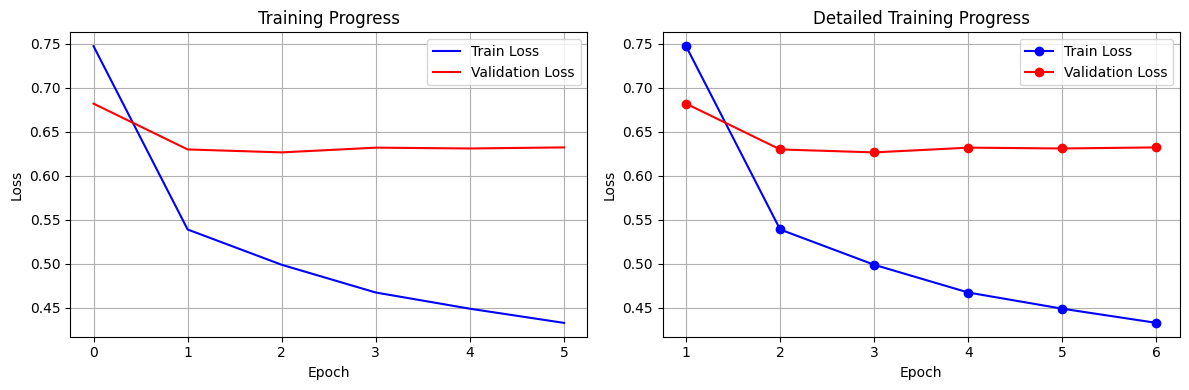

In [13]:
# ============================================================================
# CELL 11: Plot Training Progress
# ============================================================================

def plot_training_progress(train_losses, val_losses):
    """Plot training and validation losses"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Detailed Training Progress')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training progress
plot_training_progress(train_losses, val_losses)


In [14]:
# ============================================================================
# CELL 12: Load Best Model for Inference
# ============================================================================

# Load the best model
checkpoint = torch.load('best_pipe_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Best model loaded (epoch {checkpoint['epoch'] + 1})")
print(f"Best validation loss: {checkpoint['val_loss']:.4f}")


Best model loaded (epoch 3)
Best validation loss: 0.6267


In [15]:
# ============================================================================
# CELL 13: Inference Functions
# ============================================================================

def predict_pipes(model, image_path, confidence_threshold=0.5):
    """Predict pipes in a single image"""
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image)
    
    # Transform
    transform = get_transform(train=False)
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Process predictions
    pred = predictions[0]
    
    # Filter by confidence
    keep = pred['scores'] > confidence_threshold
    boxes = pred['boxes'][keep].cpu().numpy()
    scores = pred['scores'][keep].cpu().numpy()
    
    return {
        'boxes': boxes,
        'scores': scores,
        'count': len(boxes),
        'original_image': image
    }

def visualize_predictions(image_path, predictions, save_path=None):
    """Visualize predictions on image (no big red total count)"""
    image = predictions['original_image'].copy()
    boxes = predictions['boxes']
    scores = predictions['scores']
    count = predictions['count']
    
    # Draw bounding boxes
    for i, (box, score) in enumerate(zip(boxes, scores)):
        x1, y1, x2, y2 = box.astype(int)
        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Draw confidence score
        cv2.putText(image, f'{score:.2f}', (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(f'Pipe Detection Results')
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


In [16]:
# ============================================================================
# CELL 14: Test on Sample Images
# ============================================================================

# Test on a few sample images
def test_sample_images():
    """Test the model on sample images"""
    
    # Get some test images
    test_images = []
    for root, dirs, files in os.walk(TEST_PATH):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                test_images.append(os.path.join(root, file))
                if len(test_images) >= 4:  # Test on 4 images
                    break
        if len(test_images) >= 4:
            break
    
    confidence_thresholds = [0.3, 0.5, 0.7]
    
    for img_path in test_images[:2]:  # Test on first 2 images
        print(f"\nTesting: {os.path.basename(img_path)}")
        
        for conf_thresh in confidence_thresholds:
            print(f"Confidence threshold: {conf_thresh}")
            
            # Predict
            predictions = predict_pipes(model, img_path, confidence_threshold=conf_thresh)
            print(f"Detected pipes: {predictions['count']}")
            
            # Visualize
            visualize_predictions(img_path, predictions)


Evaluating: 100%|██████████| 15/15 [01:22<00:00,  5.47s/it]

Evaluation Results (Confidence: 0.5):
Mean Absolute Error: 11.33
Root Mean Squared Error: 35.00
Exact Count Accuracy: 21.67%


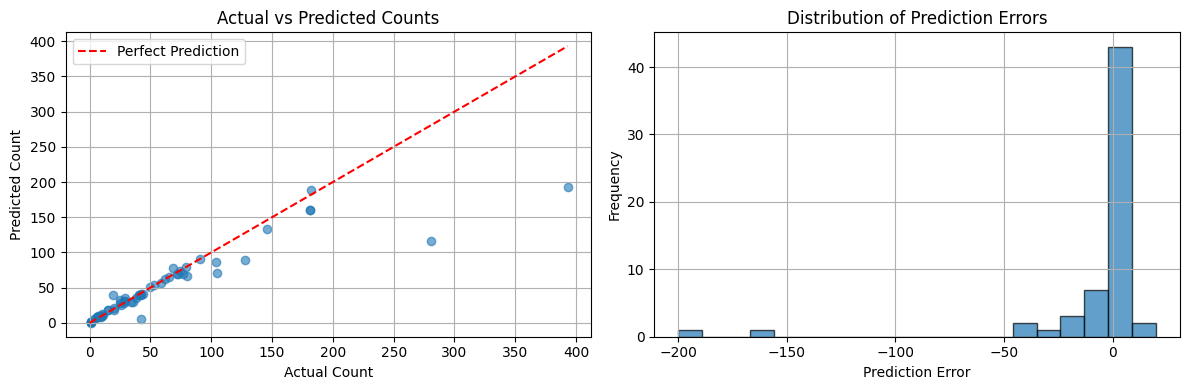

In [17]:
# ============================================================================
# CELL 15: Evaluation on Test Set
# ============================================================================

def evaluate_counting_accuracy(model, test_loader, confidence_threshold=0.5):
    """Evaluate counting accuracy on test set"""
    model.eval()
    
    predicted_counts = []
    actual_counts = []
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            # Move to device
            images = [img.to(device) for img in images]
            
            # Get predictions
            predictions = model(images)
            
            # Process each image in batch
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                # Filter by confidence
                keep = pred['scores'] > confidence_threshold
                pred_count = keep.sum().item()
                actual_count = len(target['boxes'])
                
                predicted_counts.append(pred_count)
                actual_counts.append(actual_count)
    
    # Calculate metrics
    predicted_counts = np.array(predicted_counts)
    actual_counts = np.array(actual_counts)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(predicted_counts - actual_counts))
    
    # Mean Squared Error
    mse = np.mean((predicted_counts - actual_counts) ** 2)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    # Accuracy (exact matches)
    accuracy = np.mean(predicted_counts == actual_counts)
    
    print(f"Evaluation Results (Confidence: {confidence_threshold}):")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Exact Count Accuracy: {accuracy:.2%}")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'accuracy': accuracy,
        'predicted': predicted_counts,
        'actual': actual_counts
    }

# Evaluate on test set if available
if test_ann_file:
    results = evaluate_counting_accuracy(model, test_loader, confidence_threshold=0.5)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.scatter(results['actual'], results['predicted'], alpha=0.6)
    plt.plot([0, max(results['actual'])], [0, max(results['actual'])], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Count')
    plt.ylabel('Predicted Count')
    plt.title('Actual vs Predicted Counts')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    errors = results['predicted'] - results['actual']
    plt.hist(errors, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


In [18]:
# ============================================================================
# CELL 16: Save Final Model and Results
# ============================================================================

# Save the final trained model
final_model_path = 'final_pipe_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': 2,
    'training_config': {
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'epochs': len(train_losses),
        'best_val_loss': best_val_loss
    }
}, final_model_path)

print(f"Final model saved to: {final_model_path}")

# Save training history
import pickle
history_path = 'training_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }, f)

print(f"Training history saved to: {history_path}")

Final model saved to: final_pipe_model.pth
Training history saved to: training_history.pkl


In [19]:
# ============================================================================
# CELL 17: Create Inference Function for New Images
# ============================================================================

def load_model_for_inference(model_path):
    """Load trained model for inference"""
    model = create_model(num_classes=2)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

def count_pipes_in_image(model, image_path, confidence_threshold=0.5):
    """Count pipes in a single image and show visualisation"""
    predictions = predict_pipes(model, image_path, confidence_threshold)
    visualize_predictions(image_path, predictions)
    return predictions['count'], predictions

# Example usage for inference
print("\nInference Example:")
print("=" * 30)
print("# To use the trained model for inference:")
print("model = load_model_for_inference('/content/drive/MyDrive/pipe_counter_final.pth')")
print("count, predictions = count_pipes_in_image(model, 'path_to_image.jpg')")
print("print(f'Number of pipes detected: {count}')")

print("\nTraining completed successfully!")
print("Model is ready for pipe counting!")


Inference Example:
# To use the trained model for inference:
model = load_model_for_inference('/content/drive/MyDrive/pipe_counter_final.pth')
count, predictions = count_pipes_in_image(model, 'path_to_image.jpg')
print(f'Number of pipes detected: {count}')

Training completed successfully!
Model is ready for pipe counting!


In [20]:
model1 = load_model_for_inference('final_pipe_model.pth')

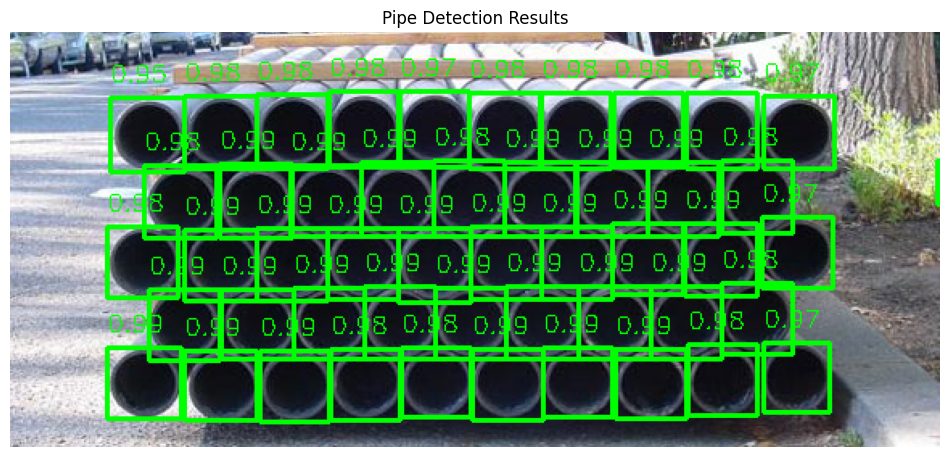

In [21]:
count = count_pipes_in_image(model1, 'water_pipes_cover1.jpg')